# Bank Loan Defaulter Hackathon Project
### Submitted by Himanshu Saini
#### Dataset Link: https://www.kaggle.com/datasets/ankitkalauni/bank-loan-defaulter-prediction-hackathon

In [1]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

In [21]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

In [32]:
# Figure saver helper (use after each plot)
def savefig(name, out_dir):
    out = Path(out_dir)
    out.mkdir(exist_ok=True, parents=True)
    plt.tight_layout()
    plt.savefig(out/name, dpi=300, bbox_inches="tight")
    print("Saved:", out)

In [4]:
# Download the data
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")

### Inspecting training data.

In [10]:
# First five rows.
df_train.head()

ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0  65087372        10000          32236             12329.36286    59   
1   1450153         3609          11940             12191.99692    59   
2   1969101        28276           9311             21603.22455    59   
3   6651430        11170           6954             17877.15585    59   
4  14354669        16890          13226             13539.92667    59   

  Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  ...  \
0     BAT2522922      11.135007     B        C4            MORTGAGE  ...   
1     BAT1586599      12.237563     C        D3                RENT  ...   
2     BAT2136391      12.545884     F        D4            MORTGAGE  ...   
3     BAT2428731      16.731201     C        C3            MORTGAGE  ...   
4     BAT5341619      15.008300     C        D4            MORTGAGE  ...   

    Recoveries Collection Recovery Fee Collection 12 months Medical  \
0     2.498291                0.793724                            0   
1     2.377215                0.974821                            0   
2     4.316277                1.020075                            0   
3     0.107020                0.749971                            0   
4  1294.818751                0.368953                            0   

  Application Type  Last week Pay  Accounts Delinquent  \
0       INDIVIDUAL             49                    0   
1       INDIVIDUAL            109                    0   
2       INDIVIDUAL             66                    0   
3       INDIVIDUAL             39                    0   
4       INDIVIDUAL             18                    0   

   Total Collection Amount  Total Current Balance  \
0                       31                 311301   
1                       53                 182610   
2                       34                  89801   
3                       40                   9189   
4                      430                 126029   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  
2                         26155            0  
3                         60214            0  
4                         22579            0  

[5 rows x 35 columns]

In [11]:
df_train.shape

(67463, 35)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [13]:
for dtype, cols in df_train.groupby(df_train.dtypes, axis=1):
    print(f"{dtype} ({len(cols.columns)} columns):")
    print(list(cols.columns))

int64 (17 columns):
['ID', 'Loan Amount', 'Funded Amount', 'Term', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Total Accounts', 'Collection 12 months Medical', 'Last week Pay', 'Accounts Delinquent', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status']
float64 (9 columns):
['Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Revolving Utilities', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee']
object (9 columns):
['Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status', 'Payment Plan', 'Loan Title', 'Initial List Status', 'Application Type']


In [14]:
# Summary statics.
df_train.describe()

ID   Loan Amount  Funded Amount  Funded Amount Investor  \
count  6.746300e+04  67463.000000   67463.000000            67463.000000   
mean   2.562761e+07  16848.902776   15770.599114            14621.799323   
std    2.109155e+07   8367.865726    8150.992662             6785.345170   
min    1.297933e+06   1014.000000    1014.000000             1114.590204   
25%    6.570288e+06  10012.000000    9266.500000             9831.684984   
50%    1.791565e+07  16073.000000   13042.000000            12793.682170   
75%    4.271521e+07  22106.000000   21793.000000            17807.594120   
max    7.224578e+07  35000.000000   34999.000000            34999.746430   

               Term  Interest Rate  Home Ownership  Debit to Income  \
count  67463.000000   67463.000000    67463.000000     67463.000000   
mean      58.173814      11.846258    80541.502522        23.299241   
std        3.327441       3.718629    45029.120366         8.451824   
min       36.000000       5.320006    14573.537170         0.675299   
25%       58.000000       9.297147    51689.843335        16.756416   
50%       59.000000      11.377696    69335.832680        22.656658   
75%       59.000000      14.193533    94623.322785        30.048400   
max       59.000000      27.182348   406561.536400        39.629862   

       Delinquency - two years  Inquires - six months  ...  \
count             67463.000000           67463.000000  ...   
mean                  0.327127               0.145754  ...   
std                   0.800888               0.473291  ...   
min                   0.000000               0.000000  ...   
25%                   0.000000               0.000000  ...   
50%                   0.000000               0.000000  ...   
75%                   0.000000               0.000000  ...   
max                   8.000000               5.000000  ...   

       Total Received Late Fee    Recoveries  Collection Recovery Fee  \
count             67463.000000  67463.000000             67463.000000   
mean                  1.143969     59.691578                 1.125141   
std                   5.244365    357.026346                 3.489885   
min                   0.000003      0.000036                 0.000036   
25%                   0.021114      1.629818                 0.476259   
50%                   0.043398      3.344524                 0.780141   
75%                   0.071884      5.453727                 1.070566   
max                  42.618882   4354.467419               166.833000   

       Collection 12 months Medical  Last week Pay  Accounts Delinquent  \
count                  67463.000000   67463.000000              67463.0   
mean                       0.021301      71.163260                  0.0   
std                        0.144385      43.315845                  0.0   
min                        0.000000       0.000000                  0.0   
25%                        0.000000      35.000000                  0.0   
50%                        0.000000      68.000000                  0.0   
75%                        0.000000     105.000000                  0.0   
max                        1.000000     161.000000                  0.0   

       Total Collection Amount  Total Current Balance  \
count             67463.000000           6.746300e+04   
mean                146.467990           1.595739e+05   
std                 744.382233           1.390332e+05   
min                   1.000000           6.170000e+02   
25%                  24.000000           5.037900e+04   
50%                  36.000000           1.183690e+05   
75%                  46.000000           2.283750e+05   
max               16421.000000           1.177412e+06   

       Total Revolving Credit Limit   Loan Status  
count                  67463.000000  67463.000000  
mean                   23123.005544      0.092510  
std                    20916.699999      0.289747  
min                     1000.000000      0.000000  
25%                     8

### Inspecting test data.

In [15]:
# First five rows.
df_test.head()

ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0  56492997        17120          10365            16025.082690    59   
1  22540813         7133          11650            12615.795600    59   
2   9862181        25291          25825            11621.280830    59   
3  10097822        30781           9664            15375.823510    59   
4  47771809         8878           9419             7176.647582    58   

  Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  ...  \
0     BAT2575549      12.163926     A        D1                RENT  ...   
1     BAT2833642       6.564296     B        E3            MORTGAGE  ...   
2     BAT1761981      14.729900     A        C3            MORTGAGE  ...   
3     BAT5341619      10.523767     A        A2                RENT  ...   
4     BAT4694572       9.997013     C        B3                 OWN  ...   

   Recoveries Collection Recovery Fee Collection 12 months Medical  \
0    8.425776                0.731797                            0   
1    6.157008                0.992918                            0   
2    5.705077                0.281580                            0   
3    2.469688                0.959162                            0   
4    2.127835                0.402315                            0   

  Application Type  Last week Pay  Accounts Delinquent  \
0       INDIVIDUAL            135                    0   
1       INDIVIDUAL             56                    0   
2       INDIVIDUAL              3                    0   
3       INDIVIDUAL             21                    0   
4       INDIVIDUAL            104                    0   

   Total Collection Amount  Total Current Balance  \
0                       24                 475442   
1                        1                  72412   
2                       26                 284825   
3                       32                  40842   
4                       33                  90825   

   Total Revolving Credit Limit  Loan Status  
0                          4364          NaN  
1                          2573          NaN  
2                         19676          NaN  
3                          7226          NaN  
4                         26145          NaN  

[5 rows x 35 columns]

In [16]:
df_test.shape

(28913, 35)

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28913 entries, 0 to 28912
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            28913 non-null  int64  
 1   Loan Amount                   28913 non-null  int64  
 2   Funded Amount                 28913 non-null  int64  
 3   Funded Amount Investor        28913 non-null  float64
 4   Term                          28913 non-null  int64  
 5   Batch Enrolled                28913 non-null  object 
 6   Interest Rate                 28913 non-null  float64
 7   Grade                         28913 non-null  object 
 8   Sub Grade                     28913 non-null  object 
 9   Employment Duration           28913 non-null  object 
 10  Home Ownership                28913 non-null  float64
 11  Verification Status           28913 non-null  object 
 12  Payment Plan                  28913 non-null  object 
 13  L

In [18]:
for dtype, cols in df_test.groupby(df_test.dtypes, axis=1):
    print(f"{dtype} ({len(cols.columns)} columns):")
    print(list(cols.columns))

int64 (16 columns):
['ID', 'Loan Amount', 'Funded Amount', 'Term', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Total Accounts', 'Collection 12 months Medical', 'Last week Pay', 'Accounts Delinquent', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit']
float64 (10 columns):
['Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Revolving Utilities', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Loan Status']
object (9 columns):
['Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status', 'Payment Plan', 'Loan Title', 'Initial List Status', 'Application Type']


In [19]:
# Summary statics.
df_test.describe()

ID   Loan Amount  Funded Amount  Funded Amount Investor  \
count  2.891300e+04  28913.000000   28913.000000            28913.000000   
mean   2.944966e+07  16404.027462   15619.911113            14741.536698   
std    2.206842e+07   8358.898287    8229.977503             7230.397758   
min    1.297893e+06   1000.000000    1000.000000             1000.000000   
25%    8.272049e+06   9776.000000    9175.000000             9695.445501   
50%    2.596622e+07  15600.000000   13200.000000            12930.601270   
75%    4.855801e+07  21651.000000   21552.000000            19226.397540   
max    7.226845e+07  35000.000000   35000.000000            35000.000000   

               Term  Interest Rate  Home Ownership  Debit to Income  \
count  28913.000000   28913.000000    28913.000000     28913.000000   
mean      54.543078      12.187577    79983.752348        22.159266   
std        8.991800       3.911259    45231.316383         8.657629   
min       36.000000       5.320000    14907.925920         0.730000   
25%       58.000000       9.422042    50791.000000        15.622891   
50%       59.000000      11.688652    68894.324470        21.530000   
75%       59.000000      14.640000    94684.941810        28.840000   
max       60.000000      27.310000   406944.859000        39.629977   

       Delinquency - two years  Inquires - six months  ...  \
count             28913.000000           28913.000000  ...   
mean                  0.332065               0.276900  ...   
std                   0.818869               0.663999  ...   
min                   0.000000               0.000000  ...   
25%                   0.000000               0.000000  ...   
50%                   0.000000               0.000000  ...   
75%                   0.000000               0.000000  ...   
max                   9.000000               5.000000  ...   

       Total Received Late Fee    Recoveries  Collection Recovery Fee  \
count             28913.000000  28913.000000             28913.000000   
mean                  0.922863     50.624944                 1.393220   
std                   4.765042    336.450176                15.139809   
min                   0.000000      0.000000                 0.000000   
25%                   0.000000      0.000000                 0.000000   
50%                   0.027878      2.165909                 0.579620   
75%                   0.061107      4.610188                 0.974739   
max                  42.520996   4325.594909               743.166000   

       Collection 12 months Medical  Last week Pay  Accounts Delinquent  \
count                  28913.000000   28913.000000         28913.000000   
mean                       0.019576      65.007574             0.000968   
std                        0.138540      42.494090             0.031105   
min                        0.000000       0.000000             0.000000   
25%                        0.000000      29.000000             0.000000   
50%                        0.000000      60.000000             0.000000   
75%                        0.000000      95.000000             0.000000   
max                        1.000000     161.000000             1.000000   

       Total Collection Amount  Total Current Balance  \
count             28913.000000           2.891300e+04   
mean                159.747553           1.530975e+05   
std                 911.671785           1.391309e+05   
min                   0.000000           6.260000e+02   
25%                   3.000000           4.397200e+04   
50%                  30.000000           1.092860e+05   
75%                  44.000000           2.222960e+05   
max               27076.000000           1.183282e+06   

       Total Revolving Credit Limit  Loan Status  
count                  28913.000000          0.0  
mean                   25013.808425          NaN  
std                    22284.519460          NaN  
min                     1000.000000          NaN  
25%                     9325.0

In [20]:
# Clean the test data (remove target column).
df_test.drop("Loan Status", axis=1, inplace=True)

In [23]:
# Identify train dataset column types.
df_train_categorical_cols = df_train.select_dtypes(include="object").columns.tolist()
df_train_numerical_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [24]:
# Identify test dataset column types.
df_test_categorical_cols = df_test.select_dtypes(include="object").columns.tolist()
df_test_numerical_cols = df_test.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [25]:
for col in df_train_numerical_cols:
    if df_train[col].nunique()<=200:
        print (col, df_train[col].nunique())

Term 3
Delinquency - two years 9
Inquires - six months 6
Open Account 36
Public Record 5
Total Accounts 69
Collection 12 months Medical 2
Last week Pay 162
Accounts Delinquent 1
Loan Status 2


In [26]:
for col in df_train_categorical_cols:
    if df_train[col].nunique()<=200:
        print (col, df_train[col].nunique())

Batch Enrolled 41
Grade 7
Sub Grade 35
Employment Duration 3
Verification Status 3
Payment Plan 1
Loan Title 109
Initial List Status 2
Application Type 2


Saved: ../results


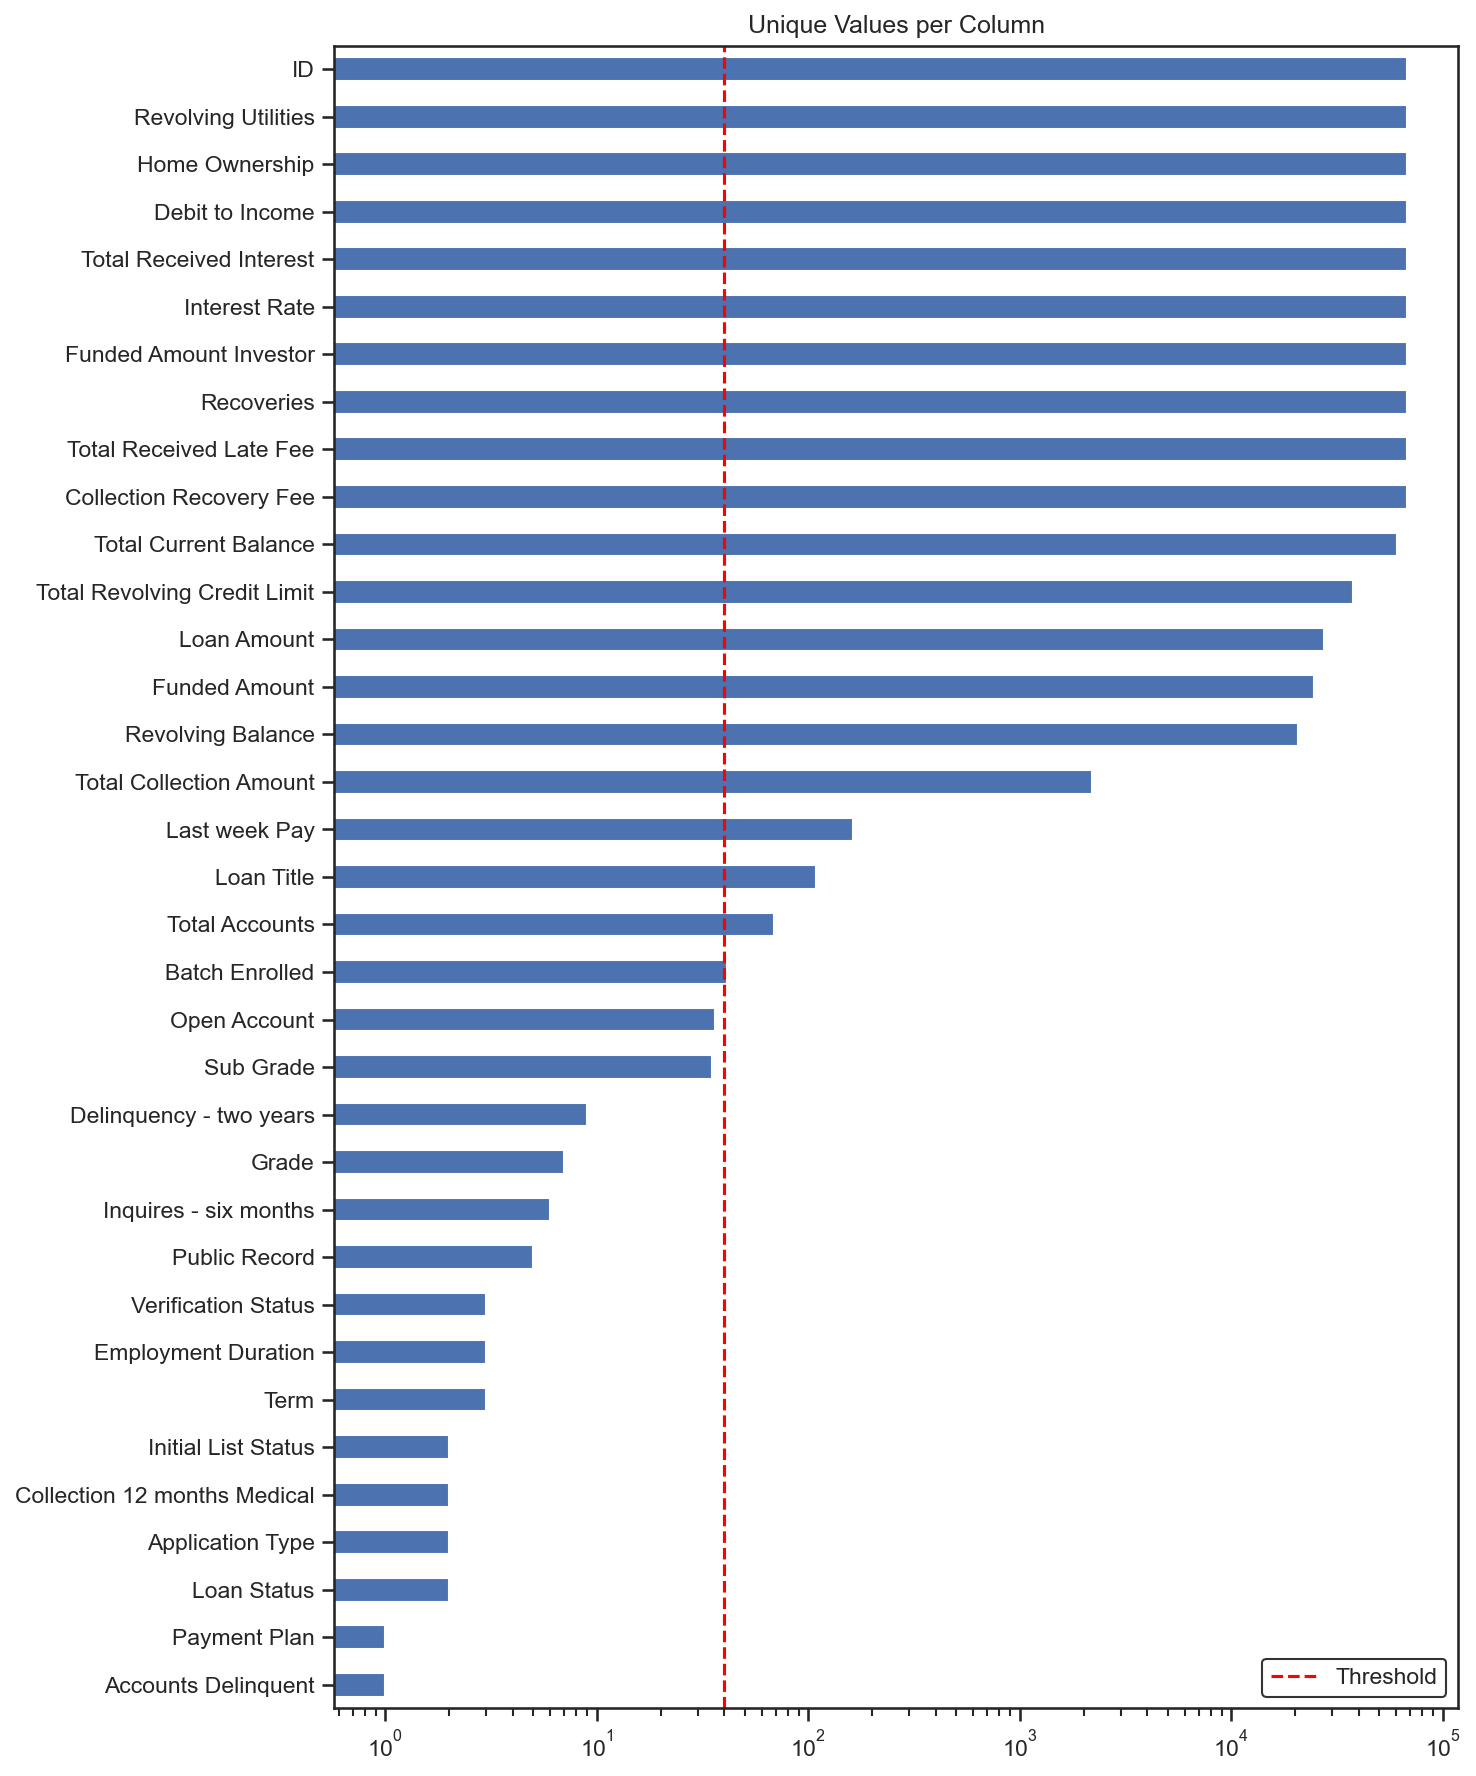

In [33]:
df_train.nunique().sort_values().plot(kind="barh", figsize=(10, 12))
plt.xscale("log")
plt.title("Unique Values per Column")
plt.axvline(x=40, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.tight_layout()
savefig("01_UniqueValuesPerColumn.png", "../results")
plt.show()

In [34]:
# Get all the categorical features out from train data.
df_train_filter = df_train.loc[:, df_train.nunique() <= 40]
df_train_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Term                          67463 non-null  int64 
 1   Grade                         67463 non-null  object
 2   Sub Grade                     67463 non-null  object
 3   Employment Duration           67463 non-null  object
 4   Verification Status           67463 non-null  object
 5   Payment Plan                  67463 non-null  object
 6   Delinquency - two years       67463 non-null  int64 
 7   Inquires - six months         67463 non-null  int64 
 8   Open Account                  67463 non-null  int64 
 9   Public Record                 67463 non-null  int64 
 10  Initial List Status           67463 non-null  object
 11  Collection 12 months Medical  67463 non-null  int64 
 12  Application Type              67463 non-null  object
 13  Accounts Delinqu

In [35]:
# Define outlier capping function (calling and flooring).
def outlier_processing(x):
     x = x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95))
     return x

In [36]:
# Apply Capping to Numeric Columns of train dataset.
df_train[df_train_numerical_cols] = df_train[df_train_numerical_cols].apply(outlier_processing)

In [37]:
# Describe Data After Capping
df_train[df_train_numerical_cols].describe(percentiles=[0.01,0.05,0.25,0.50,0.75,0.95,0.99])

ID   Loan Amount  Funded Amount  Funded Amount Investor  \
count  6.746300e+04  67463.000000   67463.000000            67463.000000   
mean   2.552438e+07  16840.495611   15767.665719            14514.832139   
std    2.081909e+07   8125.781138    7945.732803             6266.006360   
min    2.281587e+06   4485.100000    5894.300000             6327.979784   
1%     2.281587e+06   4485.100000    5894.300000             6327.979784   
5%     2.281615e+06   4485.190000    5894.570000             6328.164049   
25%    6.570288e+06  10012.000000    9266.500000             9831.684984   
50%    1.791565e+07  16073.000000   13042.000000            12793.682170   
75%    4.271521e+07  22106.000000   21793.000000            17807.594120   
95%    6.373257e+07  31741.000000   32112.620000            28884.718312   
99%    6.373261e+07  31741.000000   32112.800000            28884.736112   
max    6.373261e+07  31741.000000   32112.800000            28884.736112   

               Term  Interest Rate  Home Ownership  Debit to Income  \
count  67463.000000   67463.000000    67463.000000     67463.000000   
mean      58.648948      11.765341    78352.882339        23.359301   
std        0.477303       3.445914    36250.109322         8.153305   
min       58.000000       6.134823    33448.726146        10.205682   
1%        58.000000       6.134823    33448.726146        10.205682   
5%        58.000000       6.134824    33448.813973        10.205727   
25%       58.000000       9.297147    51689.843335        16.756416   
50%       59.000000      11.377696    69335.832680        22.656658   
75%       59.000000      14.193533    94623.322785        30.048400   
95%       59.000000      18.600084   168295.942487        37.396615   
99%       59.000000      18.600114   168296.717630        37.396621   
max       59.000000      18.600114   168296.717630        37.396621   

       Delinquency - two years  Inquires - six months  ...  \
count             67463.000000           67463.000000  ...   
mean                  0.282851               0.103420  ...   
std                   0.558337               0.304508  ...   
min                   0.000000               0.000000  ...   
1%                    0.000000               0.000000  ...   
5%                    0.000000               0.000000  ...   
25%                   0.000000               0.000000  ...   
50%                   0.000000               0.000000  ...   
75%                   0.000000               0.000000  ...   
95%                   2.000000               1.000000  ...   
99%                   2.000000               1.000000  ...   
max                   2.000000               1.000000  ...   

       Total Received Late Fee    Recoveries  Collection Recovery Fee  \
count             67463.000000  67463.000000             67463.000000   
mean                  0.050901      3.745743                 0.775216   
std                   0.037518      2.527430                 0.375993   
min                   0.004222      0.331312                 0.130243   
1%                    0.004222      0.331312                 0.130243   
5%                    0.004222      0.331313                 0.130252   
25%                   0.021114      1.629818                 0.476259   
50%                   0.043398      3.344524                 0.780141   
75%                   0.071884      5.453727                 1.070566   
95%                   0.148001      9.183840                 1.426478   
99%                   0.148031      9.183859                 1.426481   
max                   0.148031      9.183859                 1.426481   

       Collection 12 months Medical  Last week Pay  Accounts Delinquent  \
count                       67463.0   67463.000000              67463.0   
mean                            0.0      70.989209                  0.0   
std                             0.0      42.439940                  0.0   
min                             0.0       9.000

In [38]:
# Variance of Columns
df_train[df_test_numerical_cols].var().sort_values()

Collection 12 months Medical    0.000000e+00
Accounts Delinquent             0.000000e+00
Total Received Late Fee         1.407618e-03
Public Record                   6.343477e-02
Inquires - six months           9.272540e-02
Collection Recovery Fee         1.413710e-01
Term                            2.278178e-01
Delinquency - two years         3.117404e-01
Recoveries                      6.387904e+00
Interest Rate                   1.187432e+01
Open Account                    3.291591e+01
Total Accounts                  5.494742e+01
Debit to Income                 6.647638e+01
Revolving Utilities             4.665167e+02
Last week Pay                   1.801149e+03
Total Collection Amount         1.251583e+04
Total Received Interest         3.367776e+06
Revolving Balance               3.651291e+07
Funded Amount Investor          3.926284e+07
Funded Amount                   6.313467e+07
Loan Amount                     6.602832e+07
Total Revolving Credit Limit    2.977849e+08
Home Owner

In [39]:
# Define thresholds
drop_threshold = 0.0001
flag_threshold = 0.05

# Drop zero/near-zero variance columns
zero_var_cols = df_train[df_test_numerical_cols].var(numeric_only=True)
zero_var_cols = zero_var_cols[zero_var_cols < drop_threshold].index.tolist()

# Flag low-variance columns for review (but not yet dropped)
low_var_cols = df_train[df_test_numerical_cols].var(numeric_only=True)
low_var_cols = low_var_cols[(low_var_cols >= drop_threshold) & (low_var_cols < flag_threshold)].index.tolist()

print("Drop these (zero or near-zero variance):", zero_var_cols)
print("Review these (low variance):", low_var_cols)

Drop these (zero or near-zero variance): ['Collection 12 months Medical', 'Accounts Delinquent']
Review these (low variance): ['Total Received Late Fee']


In [40]:
# Initialize result dictionary
cat_analysis = {}

# Thresholds
dominance_threshold = 0.95
high_card_threshold = 100

# Analyze each categorical column
for col in df_test_categorical_cols:
    n_unique = df_train[col].nunique(dropna=False)
    top_freq = df_train[col].value_counts(normalize=True, dropna=False).iloc[0]
    cat_analysis[col] = {
        "Unique Values": n_unique,
        "Top Category %": round(top_freq * 100, 2),
        "Drop (High Cardinality)": n_unique > high_card_threshold,
        "Drop (Dominant Category)": top_freq > dominance_threshold
    }

# Convert to DataFrame
cat_analysis_df = pd.DataFrame(cat_analysis).T.sort_values(by="Unique Values")

In [41]:
cat_analysis_df

Unique Values Top Category % Drop (High Cardinality)  \
Payment Plan                    1          100.0                   False   
Initial List Status             2          53.81                   False   
Application Type                2          99.82                   False   
Employment Duration             3          53.88                   False   
Verification Status             3          48.97                   False   
Grade                           7          28.29                   False   
Sub Grade                      35           6.61                   False   
Batch Enrolled                 41           5.37                   False   
Loan Title                    109          45.55                    True   

                    Drop (Dominant Category)  
Payment Plan                            True  
Initial List Status                    False  
Application Type                        True  
Employment Duration                    False  
Verification Status                    False  
Grade                                  False  
Sub Grade                              False  
Batch Enrolled                         False  
Loan Title                             False

### From the above analysis we found the following:
### 1. Drop numerical col "Collection 12 months Medical", "Accounts Delinquent" because they have zero variance therefore, should drop.
### 2. Drop categorical col "Payment Plan", "Application Type" because contant values and highly imbalance.

In [42]:
drop_col = ['ID', 'Collection 12 months Medical', 'Accounts Delinquent', 'Payment Plan', 'Application Type']
df_train.drop(columns=drop_col, inplace=True)
df_test.drop(columns=[col for col in drop_col if col in df_test.columns], inplace=True)

In [43]:
df_test.head()

Loan Amount  Funded Amount  Funded Amount Investor  Term Batch Enrolled  \
0        17120          10365            16025.082690    59     BAT2575549   
1         7133          11650            12615.795600    59     BAT2833642   
2        25291          25825            11621.280830    59     BAT1761981   
3        30781           9664            15375.823510    59     BAT5341619   
4         8878           9419             7176.647582    58     BAT4694572   

   Interest Rate Grade Sub Grade Employment Duration  Home Ownership  ...  \
0      12.163926     A        D1                RENT     76468.82190  ...   
1       6.564296     B        E3            MORTGAGE     38079.01344  ...   
2      14.729900     A        C3            MORTGAGE     51275.93268  ...   
3      10.523767     A        A2                RENT     68867.98965  ...   
4       9.997013     C        B3                 OWN     91556.85423  ...   

  Total Accounts Initial List Status  Total Received Interest  \
0              5                   f              4469.449851   
1             21                   w               993.907530   
2             23                   f               729.113379   
3             28                   w               715.867091   
4              9                   w               248.572854   

   Total Received Late Fee  Recoveries  Collection Recovery Fee  \
0                 0.088031    8.425776                 0.731797   
1                 0.041237    6.157008                 0.992918   
2                 0.021745    5.705077                 0.281580   
3                 0.092398    2.469688                 0.959162   
4                 0.010354    2.127835                 0.402315   

   Last week Pay  Total Collection Amount  Total Current Balance  \
0            135                       24                 475442   
1             56                        1                  72412   
2              3                       26                 284825   
3             21                       32                  40842   
4            104                       33                  90825   

   Total Revolving Credit Limit  
0                          4364  
1                          2573  
2                         19676  
3                          7226  
4                         26145  

[5 rows x 29 columns]

In [44]:
# Combine Train & Test for Uniform Processing.
# use keys to track the data.
df_combined = pd.concat([df_train, df_test], axis=0, keys=["train", "test"])

In [45]:
df_train.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Loan Title', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Last week Pay', 'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [46]:
df_combined.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Loan Title', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Last week Pay', 'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [47]:
# Select categorical columns
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

# Prepare summary
encoding_suggestions = []

for col in cat_cols:
    unique_vals = df_train[col].nunique(dropna=False)
    top_cat_pct = df_train[col].value_counts(normalize=True, dropna=False).iloc[0] # The percentage of rows that belong to the most frequent category in a given column.

    if unique_vals <= 10:
        if col in ['Grade']:  # Known ordinal from domain
            encoding_type = "Ordinal Encoding"
        else:
            encoding_type = "One-Hot Encoding"
    elif 10 < unique_vals <= 50:
        encoding_type = "Label Encoding"
    elif unique_vals > 50:
        encoding_type = "Frequency Encoding / Target Encoding"
    else:
        encoding_type = "Review Manually"

    dominance_flag = "Dominant Category" if top_cat_pct > 0.95 else ""
    
    encoding_suggestions.append({
        "Column": col,
        "Unique Values": unique_vals,
        "Top Category %": round(top_cat_pct * 100, 2),
        "Suggested Encoding": encoding_type,
        "Note": dominance_flag
    })

# Convert to DataFrame
encoding_df = pd.DataFrame(encoding_suggestions).sort_values(by="Unique Values")

In [48]:
encoding_df

Column  Unique Values  Top Category %  \
6  Initial List Status              2           53.81   
3  Employment Duration              3           53.88   
4  Verification Status              3           48.97   
1                Grade              7           28.29   
2            Sub Grade             35            6.61   
0       Batch Enrolled             41            5.37   
5           Loan Title            109           45.55   

                     Suggested Encoding Note  
6                      One-Hot Encoding       
3                      One-Hot Encoding       
4                      One-Hot Encoding       
1                      Ordinal Encoding       
2                        Label Encoding       
0                        Label Encoding       
5  Frequency Encoding / Target Encoding

In [49]:
# Implemnting encoding

from sklearn.preprocessing import LabelEncoder

# --- 1. Ordinal Encoding for 'Grade'
grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df_combined["Grade"] = df_combined["Grade"].map(grade_order)

# --- 2. Label Encoding for 'Sub Grade' and 'Batch Enrolled'
label_cols = ["Sub Grade", "Batch Enrolled"]
le = LabelEncoder()
for col in label_cols:
    df_combined[col] = le.fit_transform(df_combined[col])

# --- 3. Frequency Encoding for 'Loan Title'
freq_map = df_combined["Loan Title"].value_counts().to_dict()
df_combined["Loan Title"] = df_combined["Loan Title"].map(freq_map)

# --- 4. One-Hot Encoding for 'Initial List Status', 'Employment Duration', 'Verification Status'
one_hot_cols = ["Initial List Status", "Employment Duration", "Verification Status"]
df_combined = pd.get_dummies(df_combined, columns=one_hot_cols, drop_first=True)

In [50]:
df_combined.head()

Loan Amount  Funded Amount  Funded Amount Investor  Term  \
train 0      10000.0        32112.8             12329.36286    59   
      1       4485.1        11940.0             12191.99692    59   
      2      28276.0         9311.0             21603.22455    59   
      3      11170.0         6954.0             17877.15585    59   
      4      16890.0        13226.0             13539.92667    59   

         Batch Enrolled  Interest Rate  Grade  Sub Grade  Home Ownership  \
train 0              16      11.135007      2         13    168296.71763   
      1               4      12.237563      3         17     39833.92100   
      2              11      12.545884      6         18     91506.69105   
      3              15      16.731201      3         12    108286.57590   
      4              32      15.008300      3         18     44234.82545   

         Loan Title  ...  Last week Pay  Total Collection Amount  \
train 0        4688  ...             49                       31   
      1       37100  ...            109                       53   
      2        4688  ...             66                       34   
      3       37100  ...             39                       40   
      4       42084  ...             18                      430   

         Total Current Balance  Total Revolving Credit Limit  Loan Status  \
train 0               311301.0                        6619.0          0.0   
      1               182610.0                       20885.0          0.0   
      2                89801.0                       26155.0          0.0   
      3                18215.3                       60214.0          0.0   
      4               126029.0                       22579.0          0.0   

         Initial List Status_w  Employment Duration_OWN  \
train 0                   True                    False   
      1                  False                    False   
      2                   True                    False   
      3                   True                    False   
      4                   True                    False   

         Employment Duration_RENT  Verification Status_Source Verified  \
train 0                     False                                False   
      1                      True                                 True   
      2                     False                                 True   
      3                     False                                 True   
      4                     False                                 True   

         Verification Status_Verified  
train 0                         False  
      1                         False  
      2                         False  
      3                         False  
      4                         False  

[5 rows x 32 columns]

In [51]:
df_combined.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Home Ownership', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Total Received Interest', 'Total Received Late Fee',
       'Recoveries', 'Collection Recovery Fee', 'Last week Pay',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status', 'Initial List Status_w',
       'Employment Duration_OWN', 'Employment Duration_RENT',
       'Verification Status_Source Verified', 'Verification Status_Verified'],
      dtype='object')

In [52]:
# Restore train and test from MultiIndex
df_train_encoded = df_combined.loc["train"].copy()
df_test_encoded = df_combined.loc["test"].copy()

In [53]:
print ("Loan Status" in df_train_encoded.columns)

True


In [54]:
print ("Loan Status" in df_test_encoded.columns)

True


In [55]:
df_test_encoded["Loan Status"].nunique()

0

In [56]:
df_test_encoded.head()

Loan Amount  Funded Amount  Funded Amount Investor  Term  Batch Enrolled  \
0      17120.0        10365.0            16025.082690    59              18   
1       7133.0        11650.0            12615.795600    59              20   
2      25291.0        25825.0            11621.280830    59               5   
3      30781.0         9664.0            15375.823510    59              32   
4       8878.0         9419.0             7176.647582    58              29   

   Interest Rate  Grade  Sub Grade  Home Ownership  Loan Title  ...  \
0      12.163926      1         15     76468.82190        3293  ...   
1       6.564296      2         22     38079.01344       42084  ...   
2      14.729900      1         12     51275.93268       37100  ...   
3      10.523767      1          1     68867.98965        4688  ...   
4       9.997013      3          7     91556.85423       37100  ...   

   Last week Pay  Total Collection Amount  Total Current Balance  \
0            135                       24               475442.0   
1             56                        1                72412.0   
2              3                       26               284825.0   
3             21                       32                40842.0   
4            104                       33                90825.0   

   Total Revolving Credit Limit  Loan Status  Initial List Status_w  \
0                        4364.0          NaN                  False   
1                        2573.0          NaN                   True   
2                       19676.0          NaN                  False   
3                        7226.0          NaN                   True   
4                       26145.0          NaN                   True   

   Employment Duration_OWN  Employment Duration_RENT  \
0                    False                      True   
1                    False                     False   
2                    False                     False   
3                    False                      True   
4                     True                     False   

   Verification Status_Source Verified  Verification Status_Verified  
0                                 True                         False  
1                                 True                         False  
2                                 True                         False  
3                                False                          True  
4                                False                          True  

[5 rows x 32 columns]

In [57]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28913 entries, 0 to 28912
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Loan Amount                          28913 non-null  float64
 1   Funded Amount                        28913 non-null  float64
 2   Funded Amount Investor               28913 non-null  float64
 3   Term                                 28913 non-null  int64  
 4   Batch Enrolled                       28913 non-null  int64  
 5   Interest Rate                        28913 non-null  float64
 6   Grade                                28913 non-null  int64  
 7   Sub Grade                            28913 non-null  int64  
 8   Home Ownership                       28913 non-null  float64
 9   Loan Title                           28913 non-null  int64  
 10  Debit to Income                      28913 non-null  float64
 11  Delinquency - two years          

### Dixtribution Analysis.

In [59]:
# Import Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

In [60]:
# Prepare Features and Target
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]
X_test = df_test_encoded.drop(columns=["Loan Status"])

print("Original Class Distribution:")
print(Counter(y))

Original Class Distribution:
Counter({0.0: 61222, 1.0: 6241})


In [61]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE")  
print(Counter(y_smote))

After SMOTE
Counter({0.0: 61222, 1.0: 61222})


In [62]:
# Apply NearMiss
nearmiss = NearMiss(version=1)
X_nm, y_nm = nearmiss.fit_resample(X, y)
print("After NearMiss:")
print(Counter(y_nm))

After NearMiss:
Counter({0.0: 6241, 1.0: 6241})


In [63]:
comparison_df = pd.DataFrame({
    "Original": pd.Series(Counter(y)),
    "SMOTE": pd.Series(Counter(y_smote)),
    "NearMiss": pd.Series(Counter(y_nm))
}).T
comparison_df.columns = ["Non-Defaulter (0)", "Defaulter (1)"]
print("Class Distribution Comparison:\n")
display(comparison_df)

Class Distribution Comparison:



Non-Defaulter (0)  Defaulter (1)
Original              61222           6241
SMOTE                 61222          61222
NearMiss               6241           6241

Saved: ../results


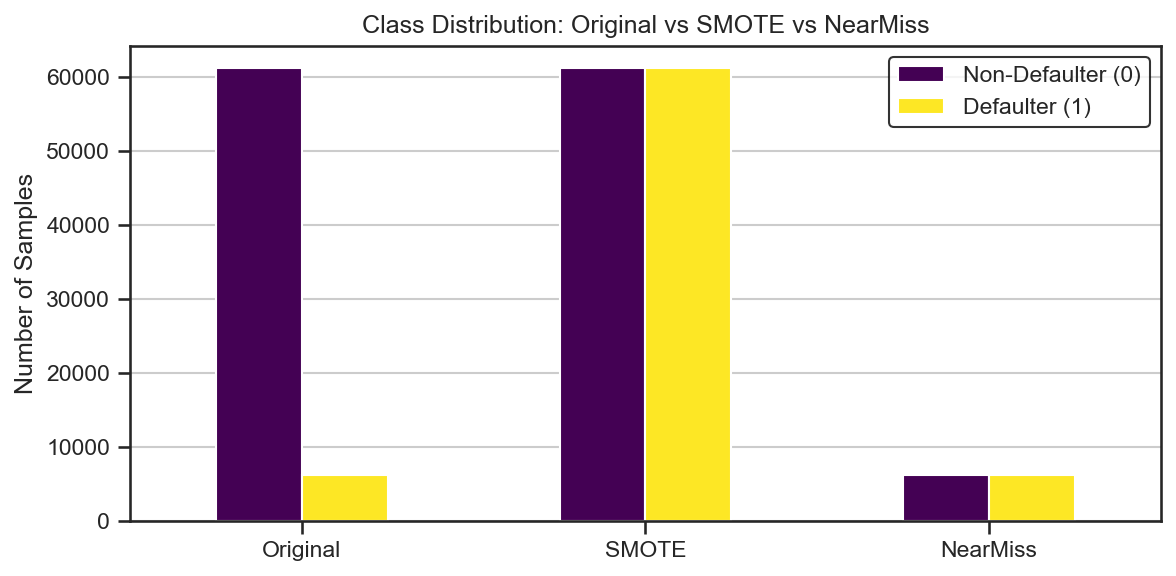

In [64]:
# Plotting
comparison_df.plot(kind="bar", figsize=(8, 4), colormap="viridis")
plt.title("Class Distribution: Original vs SMOTE vs NearMiss")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
savefig("02_DistributionPlot.png", "../results")
plt.show()

### ML Modeling

In [65]:
X.head()

Loan Amount  Funded Amount  Funded Amount Investor  Term  Batch Enrolled  \
0      10000.0        32112.8             12329.36286    59              16   
1       4485.1        11940.0             12191.99692    59               4   
2      28276.0         9311.0             21603.22455    59              11   
3      11170.0         6954.0             17877.15585    59              15   
4      16890.0        13226.0             13539.92667    59              32   

   Interest Rate  Grade  Sub Grade  Home Ownership  Loan Title  ...  \
0      11.135007      2         13    168296.71763        4688  ...   
1      12.237563      3         17     39833.92100       37100  ...   
2      12.545884      6         18     91506.69105        4688  ...   
3      16.731201      3         12    108286.57590       37100  ...   
4      15.008300      3         18     44234.82545       42084  ...   

   Collection Recovery Fee  Last week Pay  Total Collection Amount  \
0                 0.793724             49                       31   
1                 0.974821            109                       53   
2                 1.020075             66                       34   
3                 0.749971             39                       40   
4                 0.368953             18                      430   

   Total Current Balance  Total Revolving Credit Limit  Initial List Status_w  \
0               311301.0                        6619.0                   True   
1               182610.0                       20885.0                  False   
2                89801.0                       26155.0                   True   
3                18215.3                       60214.0                   True   
4               126029.0                       22579.0                   True   

   Employment Duration_OWN  Employment Duration_RENT  \
0                    False                     False   
1                    False                      True   
2                    False                     False   
3                    False                     False   
4                    False                     False   

   Verification Status_Source Verified  Verification Status_Verified  
0                                False                         False  
1                                 True                         False  
2                                 True                         False  
3                                 True                         False  
4                                 True                         False  

[5 rows x 31 columns]

In [66]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Loan Status, dtype: float64

In [67]:
X_test.head()

Loan Amount  Funded Amount  Funded Amount Investor  Term  Batch Enrolled  \
0      17120.0        10365.0            16025.082690    59              18   
1       7133.0        11650.0            12615.795600    59              20   
2      25291.0        25825.0            11621.280830    59               5   
3      30781.0         9664.0            15375.823510    59              32   
4       8878.0         9419.0             7176.647582    58              29   

   Interest Rate  Grade  Sub Grade  Home Ownership  Loan Title  ...  \
0      12.163926      1         15     76468.82190        3293  ...   
1       6.564296      2         22     38079.01344       42084  ...   
2      14.729900      1         12     51275.93268       37100  ...   
3      10.523767      1          1     68867.98965        4688  ...   
4       9.997013      3          7     91556.85423       37100  ...   

   Collection Recovery Fee  Last week Pay  Total Collection Amount  \
0                 0.731797            135                       24   
1                 0.992918             56                        1   
2                 0.281580              3                       26   
3                 0.959162             21                       32   
4                 0.402315            104                       33   

   Total Current Balance  Total Revolving Credit Limit  Initial List Status_w  \
0               475442.0                        4364.0                  False   
1                72412.0                        2573.0                   True   
2               284825.0                       19676.0                  False   
3                40842.0                        7226.0                   True   
4                90825.0                       26145.0                   True   

   Employment Duration_OWN  Employment Duration_RENT  \
0                    False                      True   
1                    False                     False   
2                    False                     False   
3                    False                      True   
4                     True                     False   

   Verification Status_Source Verified  Verification Status_Verified  
0                                 True                         False  
1                                 True                         False  
2                                 True                         False  
3                                False                          True  
4                                False                          True  

[5 rows x 31 columns]

In [139]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics (for classification)
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import log_loss

# Model Selection (Optional for tuning)
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


In [69]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    con_mat = confusion_matrix(y_test, y_pred)

    print(f"Results: {name}")
    print("-" * 40)
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC AUC Score : {roc_auc:.4f}" if roc_auc is not None else "ROC AUC not available")
    print("\nConfusion Matrix:")
    print(con_mat)
    print("-" * 40)

    # Add feature importance if supported
    feature_importance = None
    if hasattr(model, "feature_importances_"):
        feature_importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        try:
            feature_importance = abs(model.coef_[0])  # Optional, if linear
        except:
            feature_importance = None
    
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Confusion Matrix": con_mat,
        "Feature Importance": feature_importance
    }

In [155]:
# Step 1: Split the data (80/20) for clean validation
from sklearn.model_selection import train_test_split

# Original (X, y).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Test case
test = df_test_encoded.drop(columns=["Loan Status"])

# Over-sampled using SMOTE (X_smote, y_smote)
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

# Under-sampled using NearMiss (X_nm, y_nm)
nearmiss = NearMiss()
X_nm_train, y_nm_train = nearmiss.fit_resample(X_train, y_train)

## Model 1. Logistic Regression

In [71]:
# Create model
lr = LogisticRegression(max_iter=1000)

# Original
result_lr_orig = evaluate_model(lr, X_train, y_train, X_test, y_test, name="LogReg - Original")

# SMOTE
result_lr_smote = evaluate_model(lr, X_smote_train, y_smote_train, X_test, y_test, name="LogReg - SMOTE")

# NearMiss
result_lr_nm = evaluate_model(lr, X_nm_train, y_nm_train, X_test, y_test, name="LogReg - NearMiss")


Results: LogReg - Original
----------------------------------------
Accuracy      : 0.9075
Precision     : 0.0000
Recall        : 0.0000
F1 Score      : 0.0000
ROC AUC Score : 0.4873

Confusion Matrix:
[[12245     0]
 [ 1248     0]]
----------------------------------------
Results: LogReg - SMOTE
----------------------------------------
Accuracy      : 0.5478
Precision     : 0.0982
Recall        : 0.4752
F1 Score      : 0.1627
ROC AUC Score : 0.5162

Confusion Matrix:
[[6798 5447]
 [ 655  593]]
----------------------------------------
Results: LogReg - NearMiss
----------------------------------------
Accuracy      : 0.3416
Precision     : 0.0942
Recall        : 0.7099
F1 Score      : 0.1663
ROC AUC Score : 0.5074

Confusion Matrix:
[[3723 8522]
 [ 362  886]]
----------------------------------------


## Model 2. Decison Tree Classifier

In [72]:
# Base model setup
dt = DecisionTreeClassifier(random_state=42)

# Original
result_dt_orig = evaluate_model(dt, X_train, y_train, X_test, y_test, name="DecisionTree - Original")

# SMOTE
result_dt_smote = evaluate_model(dt, X_smote_train, y_smote_train, X_test, y_test, name="DecisionTree - SMOTE")

# NearMiss
result_dt_nm = evaluate_model(dt, X_nm_train, y_nm_train, X_test, y_test, name="DecisionTree - NearMiss")

Results: DecisionTree - Original
----------------------------------------
Accuracy      : 0.8147
Precision     : 0.0961
Recall        : 0.1194
F1 Score      : 0.1065
ROC AUC Score : 0.5025

Confusion Matrix:
[[10844  1401]
 [ 1099   149]]
----------------------------------------
Results: DecisionTree - SMOTE
----------------------------------------
Accuracy      : 0.7511
Precision     : 0.0905
Recall        : 0.1867
F1 Score      : 0.1219
ROC AUC Score : 0.4977

Confusion Matrix:
[[9902 2343]
 [1015  233]]
----------------------------------------
Results: DecisionTree - NearMiss
----------------------------------------
Accuracy      : 0.3282
Precision     : 0.0948
Recall        : 0.7332
F1 Score      : 0.1680
ROC AUC Score : 0.5100

Confusion Matrix:
[[3513 8732]
 [ 333  915]]
----------------------------------------


## Model 3. Random Forest Classifier

In [73]:
# Initialize with base settings
rf = RandomForestClassifier(random_state=42)

# Original
result_rf_orig = evaluate_model(rf, X_train, y_train, X_test, y_test, name="RandomForest - Original")

# SMOTE
result_rf_smote = evaluate_model(rf, X_smote_train, y_smote_train, X_test, y_test, name="RandomForest - SMOTE")

# NearMiss
result_rf_nm = evaluate_model(rf, X_nm_train, y_nm_train, X_test, y_test, name="RandomForest - NearMiss")

Results: RandomForest - Original
----------------------------------------
Accuracy      : 0.9075
Precision     : 0.0000
Recall        : 0.0000
F1 Score      : 0.0000
ROC AUC Score : 0.5161

Confusion Matrix:
[[12245     0]
 [ 1248     0]]
----------------------------------------
Results: RandomForest - SMOTE
----------------------------------------
Accuracy      : 0.8859
Precision     : 0.0899
Recall        : 0.0256
F1 Score      : 0.0399
ROC AUC Score : 0.5068

Confusion Matrix:
[[11921   324]
 [ 1216    32]]
----------------------------------------
Results: RandomForest - NearMiss
----------------------------------------
Accuracy      : 0.2893
Precision     : 0.0940
Recall        : 0.7732
F1 Score      : 0.1675
ROC AUC Score : 0.5058

Confusion Matrix:
[[2939 9306]
 [ 283  965]]
----------------------------------------


## Model 4: Support Vector Classifier

In [74]:
# Initialize with probability enabled for ROC AUC
svc = SVC(probability=True, random_state=42)

# Original
result_svc_orig = evaluate_model(svc, X_train, y_train, X_test, y_test, name="SVC - Original")

# SMOTE
result_svc_smote = evaluate_model(svc, X_smote_train, y_smote_train, X_test, y_test, name="SVC - SMOTE")

# NearMiss
result_svc_nm = evaluate_model(svc, X_nm_train, y_nm_train, X_test, y_test, name="SVC - NearMiss")

Results: SVC - Original
----------------------------------------
Accuracy      : 0.9075
Precision     : 0.0000
Recall        : 0.0000
F1 Score      : 0.0000
ROC AUC Score : 0.5006

Confusion Matrix:
[[12245     0]
 [ 1248     0]]
----------------------------------------
Results: SVC - SMOTE
----------------------------------------
Accuracy      : 0.5197
Precision     : 0.0978
Recall        : 0.5096
F1 Score      : 0.1641
ROC AUC Score : 0.5165

Confusion Matrix:
[[6376 5869]
 [ 612  636]]
----------------------------------------
Results: SVC - NearMiss
----------------------------------------
Accuracy      : 0.3461
Precision     : 0.0917
Recall        : 0.6819
F1 Score      : 0.1617
ROC AUC Score : 0.4992

Confusion Matrix:
[[3819 8426]
 [ 397  851]]
----------------------------------------


## Model 5: XGBoost

In [75]:
# Initialize XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Evaluate on Original Data
result_xgb_orig = evaluate_model(xgb, X_train, y_train, X_test, y_test, name="XGBoost - Original")

# Evaluate on SMOTE-balanced Data
result_xgb_smote = evaluate_model(xgb, X_smote_train, y_smote_train, X_test, y_test, name="XGBoost - SMOTE")

# Evaluate on NearMiss-balanced Data
result_xgb_nm = evaluate_model(xgb, X_nm_train, y_nm_train, X_test, y_test, name="XGBoost - NearMiss")


Results: XGBoost - Original
----------------------------------------
Accuracy      : 0.9062
Precision     : 0.0526
Recall        : 0.0008
F1 Score      : 0.0016
ROC AUC Score : 0.5128

Confusion Matrix:
[[12227    18]
 [ 1247     1]]
----------------------------------------
Results: XGBoost - SMOTE
----------------------------------------
Accuracy      : 0.8481
Precision     : 0.0908
Recall        : 0.0713
F1 Score      : 0.0799
ROC AUC Score : 0.5019

Confusion Matrix:
[[11354   891]
 [ 1159    89]]
----------------------------------------
Results: XGBoost - NearMiss
----------------------------------------
Accuracy      : 0.2945
Precision     : 0.0944
Recall        : 0.7708
F1 Score      : 0.1681
ROC AUC Score : 0.5092

Confusion Matrix:
[[3012 9233]
 [ 286  962]]
----------------------------------------


In [76]:
model_metrices = pd.DataFrame([result_lr_orig, result_lr_smote, result_lr_nm, result_dt_orig, result_dt_smote, result_dt_nm, result_rf_orig, result_rf_smote, result_rf_nm, result_svc_orig, result_svc_smote, result_svc_nm, result_xgb_orig, result_xgb_smote, result_xgb_nm])

In [77]:
model_metrices

Model  Accuracy  Precision    Recall  F1 Score  \
0         LogReg - Original  0.907508   0.000000  0.000000  0.000000   
1            LogReg - SMOTE  0.547766   0.098179  0.475160  0.162733   
2         LogReg - NearMiss  0.341585   0.094175  0.709936  0.166291   
3   DecisionTree - Original  0.814719   0.096129  0.119391  0.106505   
4      DecisionTree - SMOTE  0.751130   0.090450  0.186699  0.121862   
5   DecisionTree - NearMiss  0.328170   0.094848  0.733173  0.167967   
6   RandomForest - Original  0.907508   0.000000  0.000000  0.000000   
7      RandomForest - SMOTE  0.885867   0.089888  0.025641  0.039900   
8   RandomForest - NearMiss  0.289335   0.093954  0.773237  0.167549   
9            SVC - Original  0.907508   0.000000  0.000000  0.000000   
10              SVC - SMOTE  0.519677   0.097771  0.509615  0.164066   
11           SVC - NearMiss  0.346105   0.091732  0.681891  0.161710   
12       XGBoost - Original  0.906248   0.052632  0.000801  0.001579   
13          XGBoost - SMOTE  0.848069   0.090816  0.071314  0.079892   
14       XGBoost - NearMiss  0.294523   0.094360  0.770833  0.168138   

     ROC AUC              Confusion Matrix  \
0   0.487310       [[12245, 0], [1248, 0]]   
1   0.516186    [[6798, 5447], [655, 593]]   
2   0.507448    [[3723, 8522], [362, 886]]   
3   0.502488  [[10844, 1401], [1099, 149]]   
4   0.497678   [[9902, 2343], [1015, 233]]   
5   0.510033    [[3513, 8732], [333, 915]]   
6   0.516068       [[12245, 0], [1248, 0]]   
7   0.506844    [[11921, 324], [1216, 32]]   
8   0.505841    [[2939, 9306], [283, 965]]   
9   0.500632       [[12245, 0], [1248, 0]]   
10  0.516501    [[6376, 5869], [612, 636]]   
11  0.499204    [[3819, 8426], [397, 851]]   
12  0.512790      [[12227, 18], [1247, 1]]   
13  0.501907    [[11354, 891], [1159, 89]]   
14  0.509189    [[3012, 9233], [286, 962]]   

                                   Feature Importance  
0   [5.922515714712579e-06, 3.1291221084502895e-06...  
1   [1.0198525131539262e-06, 8.058089588853066e-07...  
2   [1.3423980476975041e-05, 5.844329452859742e-05...  
3   [0.047756031588325455, 0.04737340382985258, 0....  
4   [0.027519808652149345, 0.028613253084519796, 0...  
5   [0.03822994983650832, 0.06844969848634824, 0.0...  
6   [0.04831752102754547, 0.04706925628907241, 0.0...  
7   [0.0288388345401192, 0.029555454629551985, 0.0...  
8   [0.04624808456520592, 0.06331577363769379, 0.0...  
9                                                None  
10                                               None  
11                                               None  
12  [0.034437053, 0.033719443, 0.034096494, 0.0340...  
13  [0.0064530894, 0.006814039, 0.006475639, 0.034...  
14  [0.032475393, 0.049204394, 0.04140563, 0.02205...

Saved: ../results


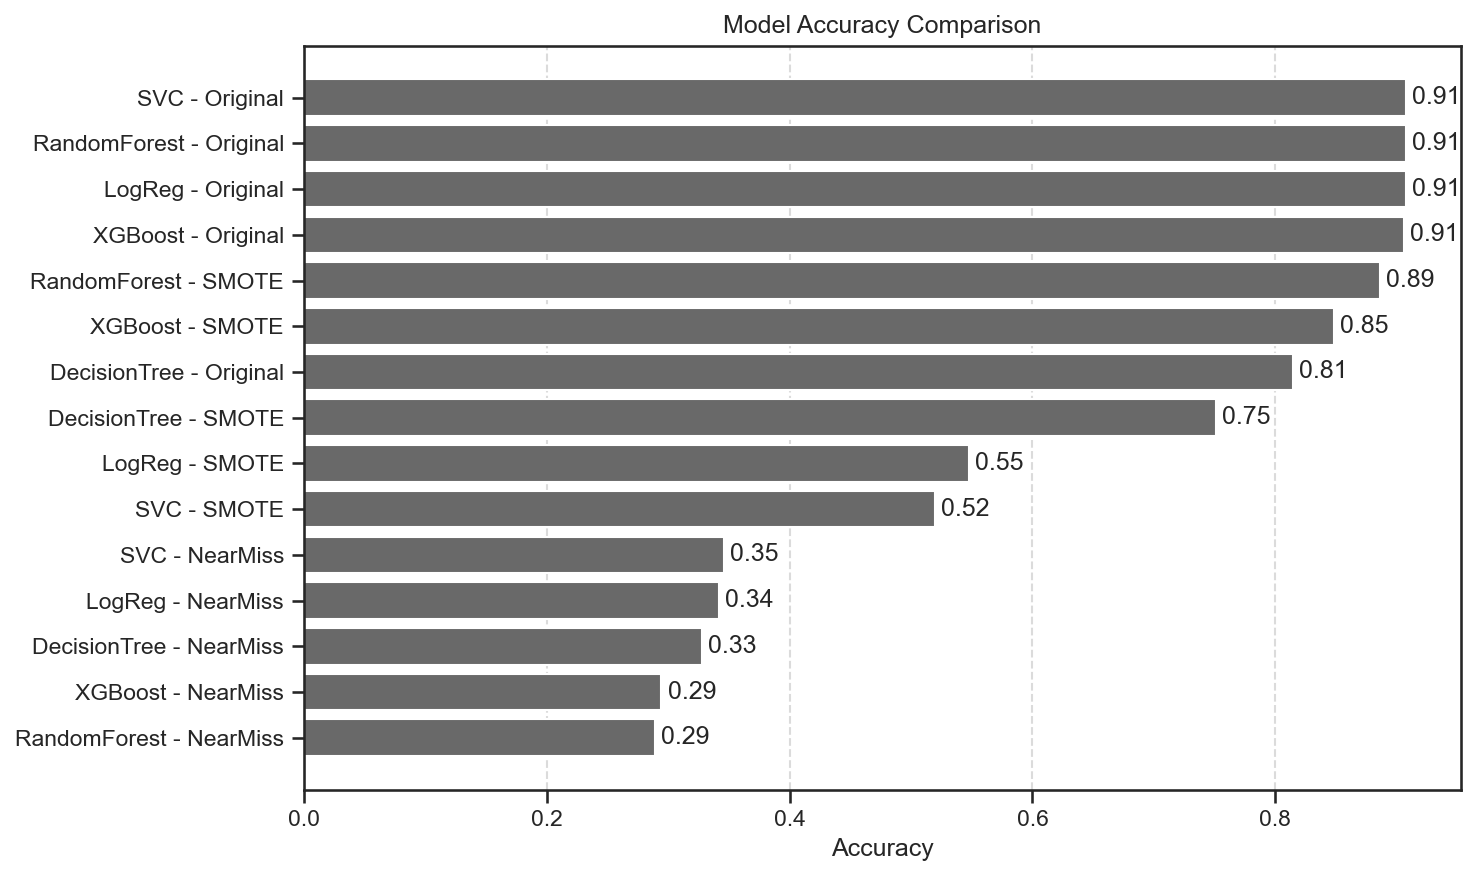

In [78]:
# PLot the Accuracies of the different models
# Sort models by Accuracy for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="Accuracy", ascending=True)["Model"], model_metrices.sort_values(by="Accuracy", ascending=True)["Accuracy"], color="dimgray")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
savefig("03_ModelAccuracyComparison.png", "../results")
plt.show()

Saved: ../results


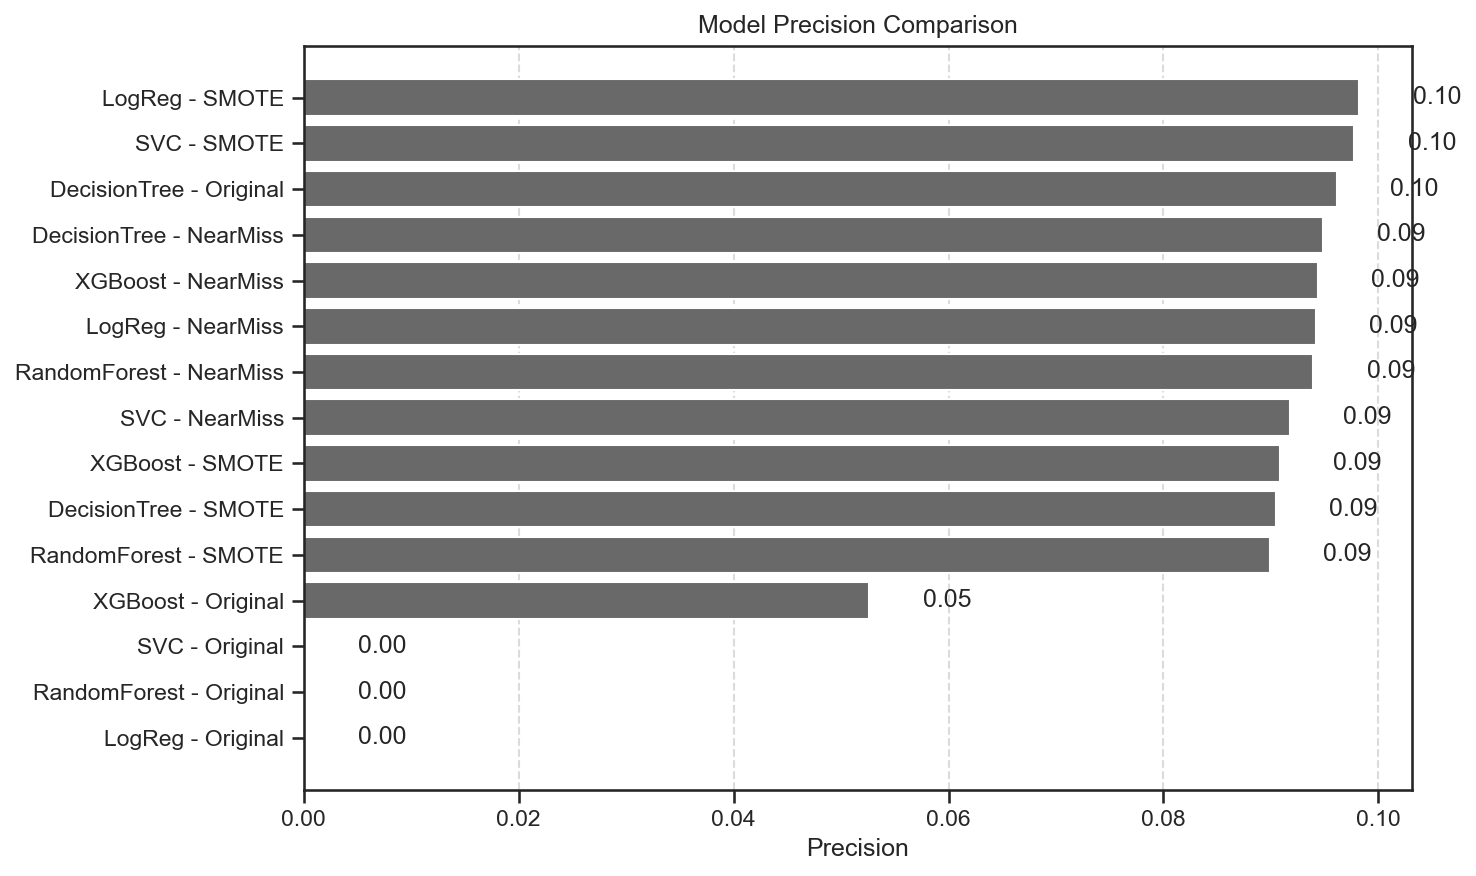

In [80]:
# PLot the Precision of the different models
# Sort models by Accuracy for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="Precision", ascending=True)["Model"], model_metrices.sort_values(by="Precision", ascending=True)["Precision"], color="dimgray")
plt.xlabel("Precision")
plt.title("Model Precision Comparison")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
savefig("04_ModelPrecisionComparison.png", "../results")
plt.show()

Saved: ../results


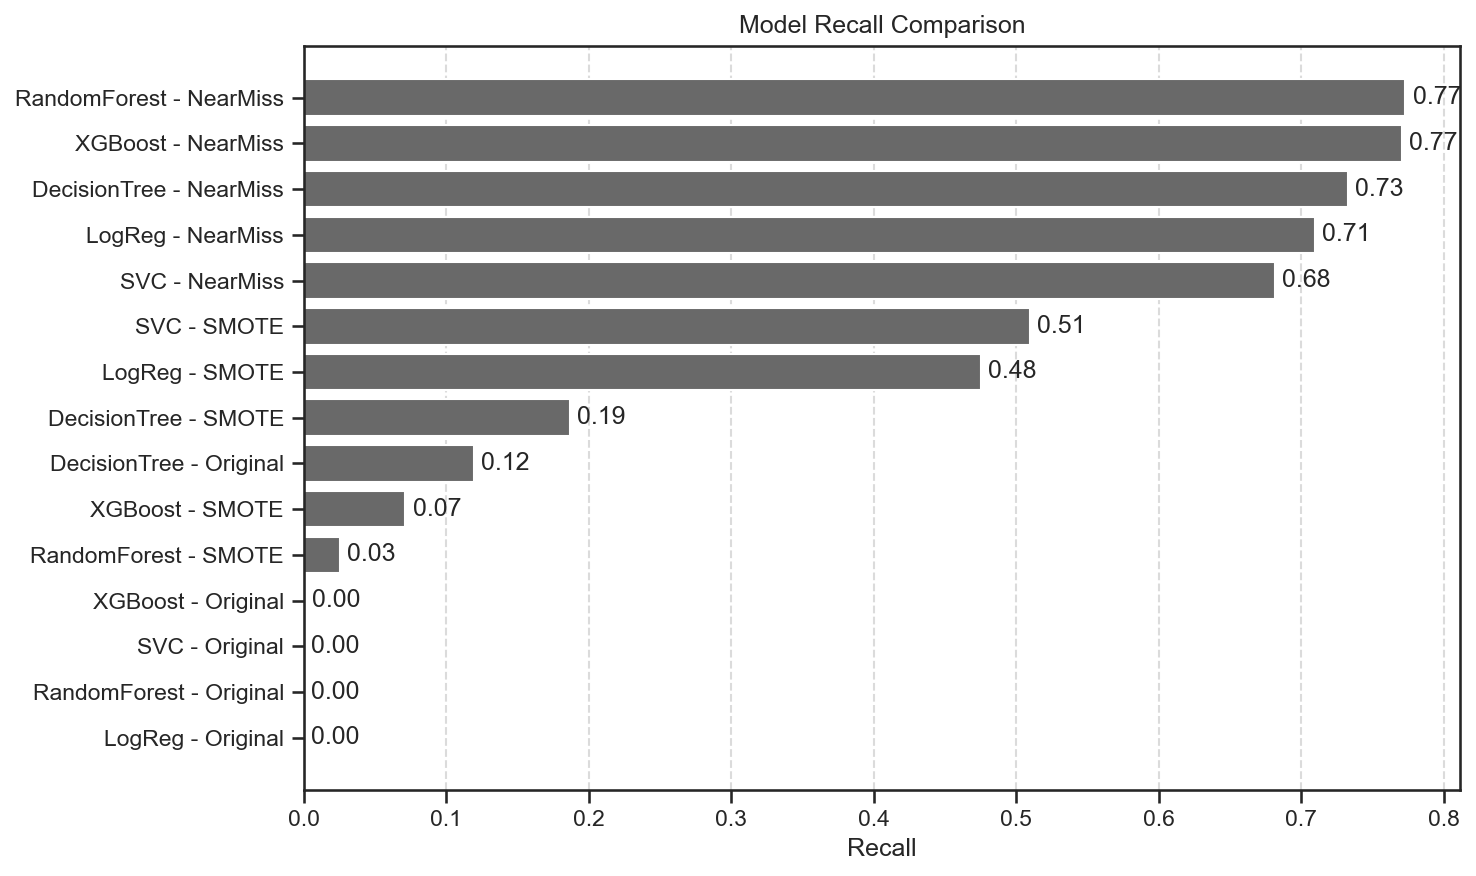

In [81]:
# PLot the Recall of the different models
# Sort models by Recall for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="Recall", ascending=True)["Model"], model_metrices.sort_values(by="Recall", ascending=True)["Recall"], color="dimgray")
plt.xlabel("Recall")
plt.title("Model Recall Comparison")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
savefig("05_ModelRecallComparison.png", "../results")
plt.show()

Saved: ../results


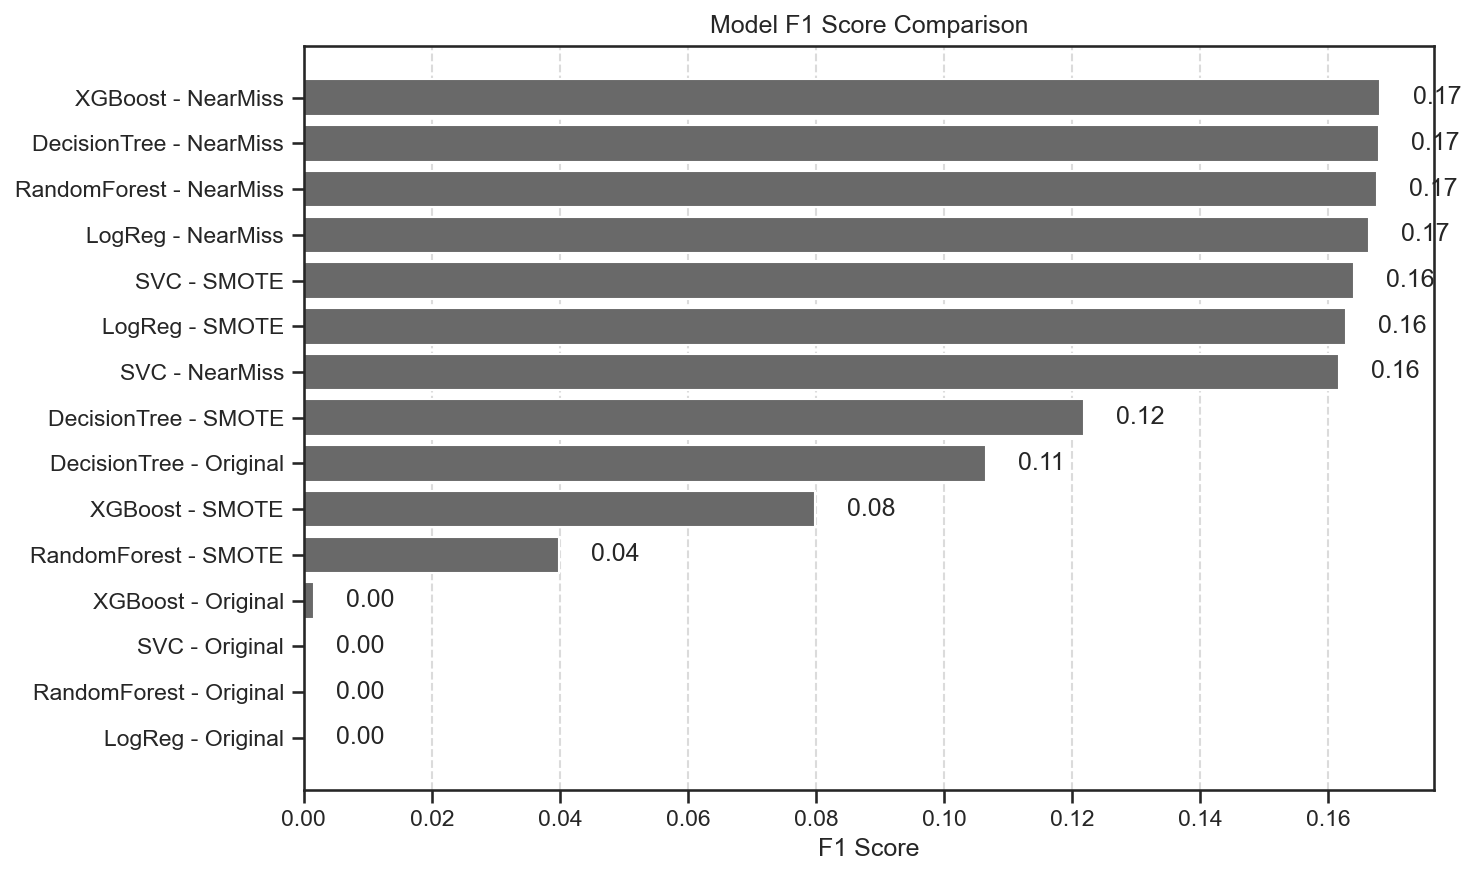

In [83]:
# PLot the F1 Score of the different models
# Sort models by Recall for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="F1 Score", ascending=True)["Model"], model_metrices.sort_values(by="F1 Score", ascending=True)["F1 Score"], color="dimgray")
plt.xlabel("F1 Score")
plt.title("Model F1 Score Comparison")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
savefig("06_ModelF1ScoreComparison.png", "../results")
plt.show()

Saved: ../results


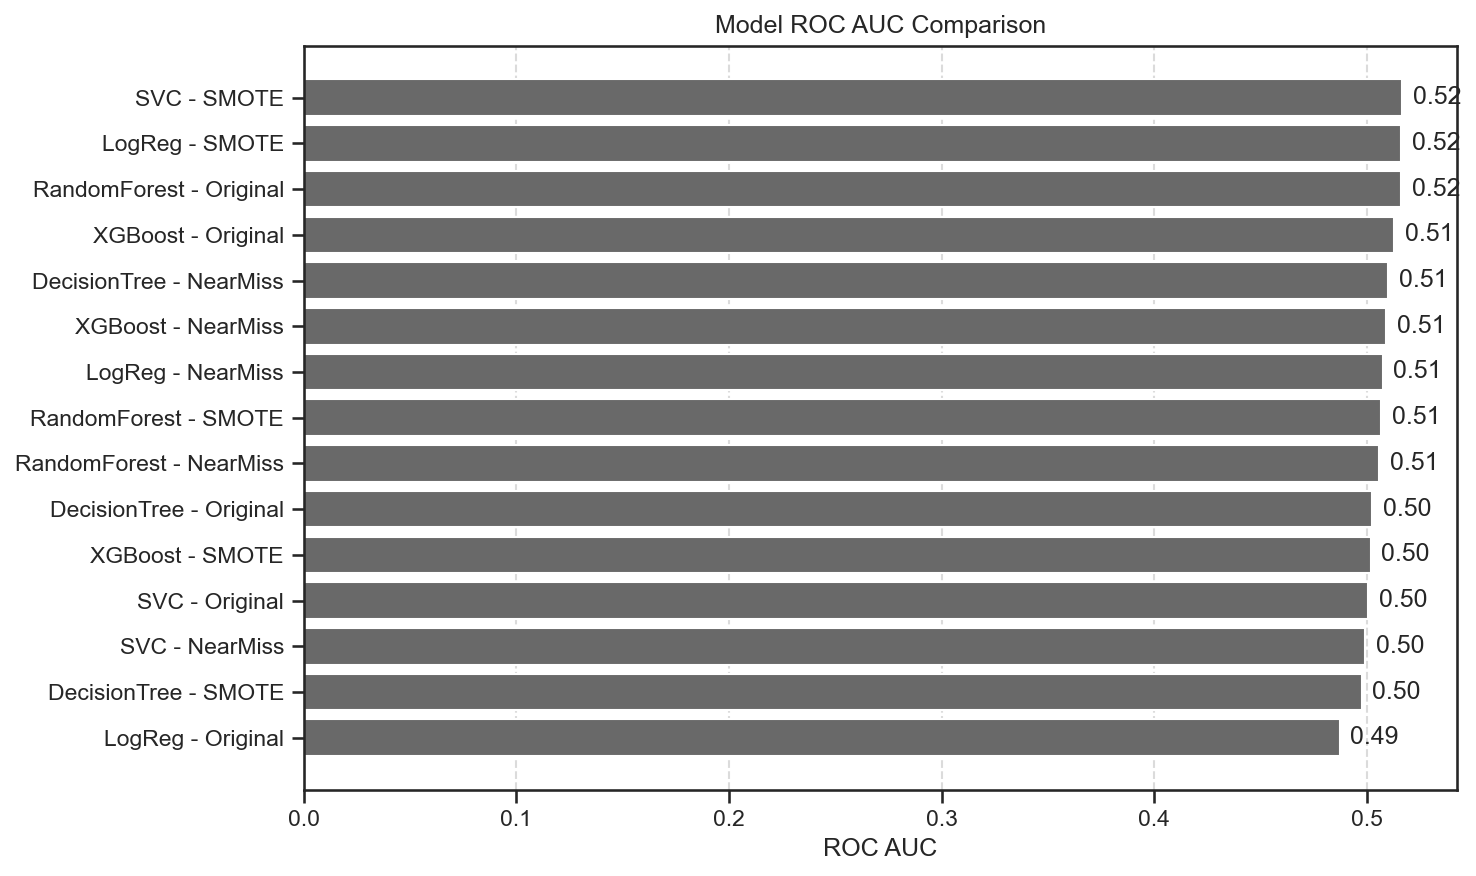

In [84]:
# PLot the ROC AUC of the different models
# Sort models by Recall for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="ROC AUC", ascending=True)["Model"], model_metrices.sort_values(by="ROC AUC", ascending=True)["ROC AUC"], color="dimgray")
plt.xlabel("ROC AUC")
plt.title("Model ROC AUC Comparison")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
savefig("07_Model_ROC_AUC_Comparison.png", "../results")
plt.show()

Saved: ../results


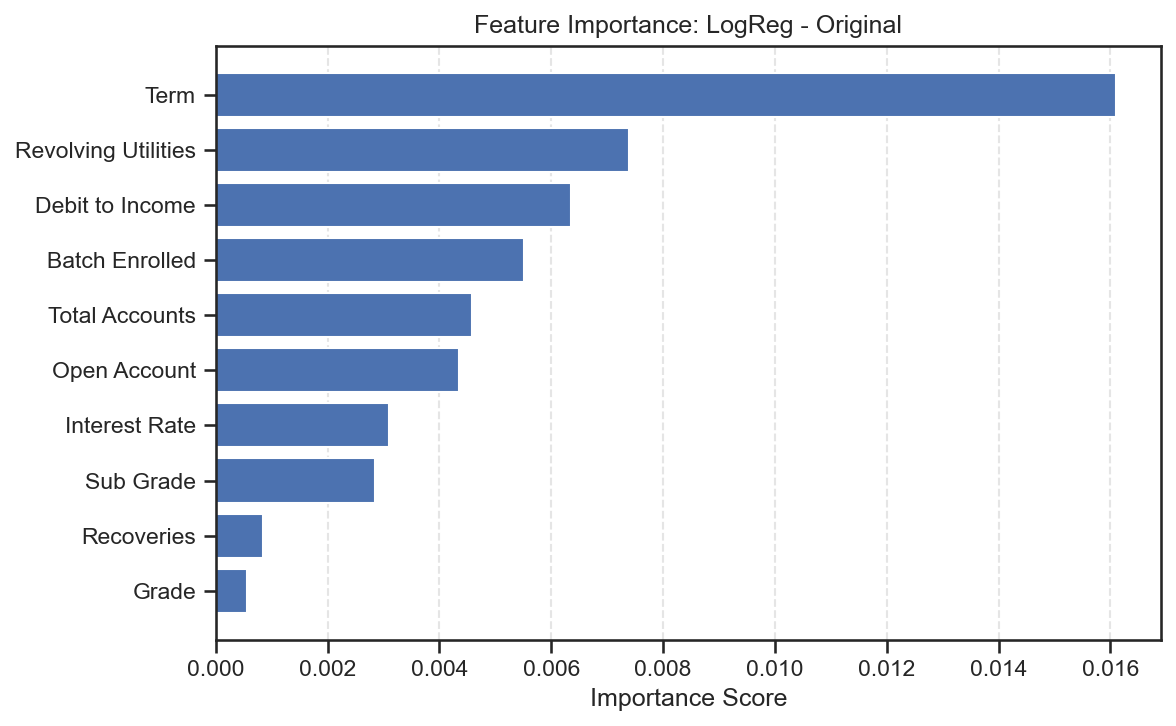

Saved: ../results


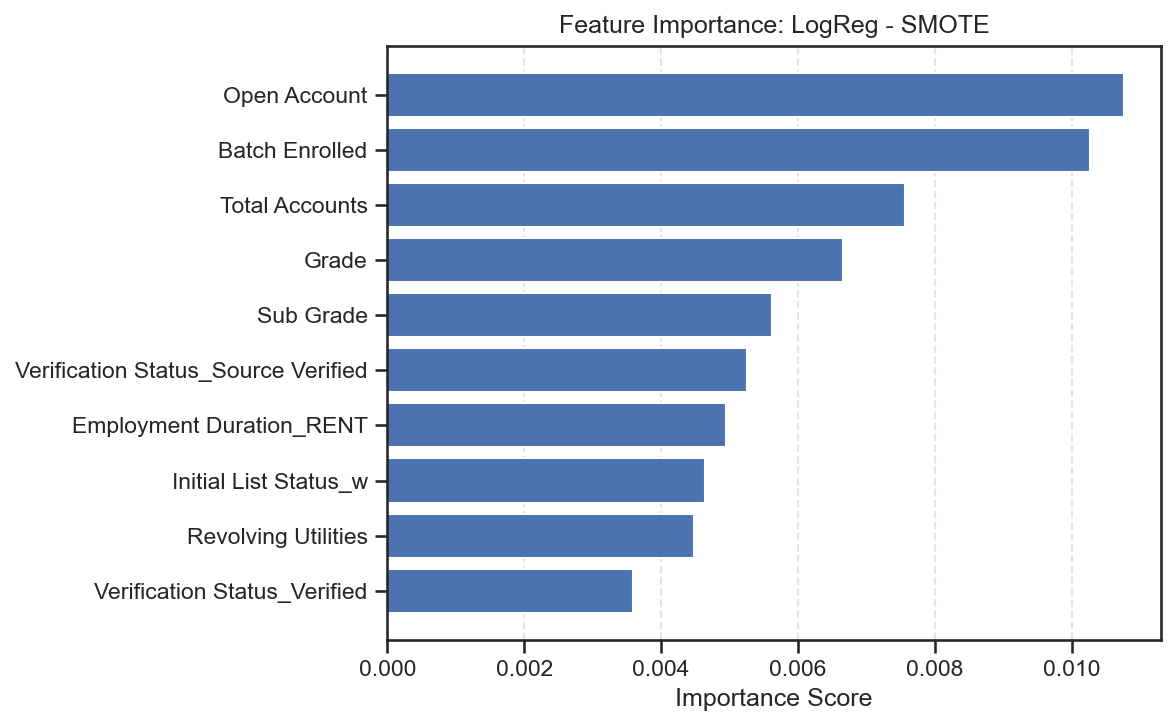

Saved: ../results


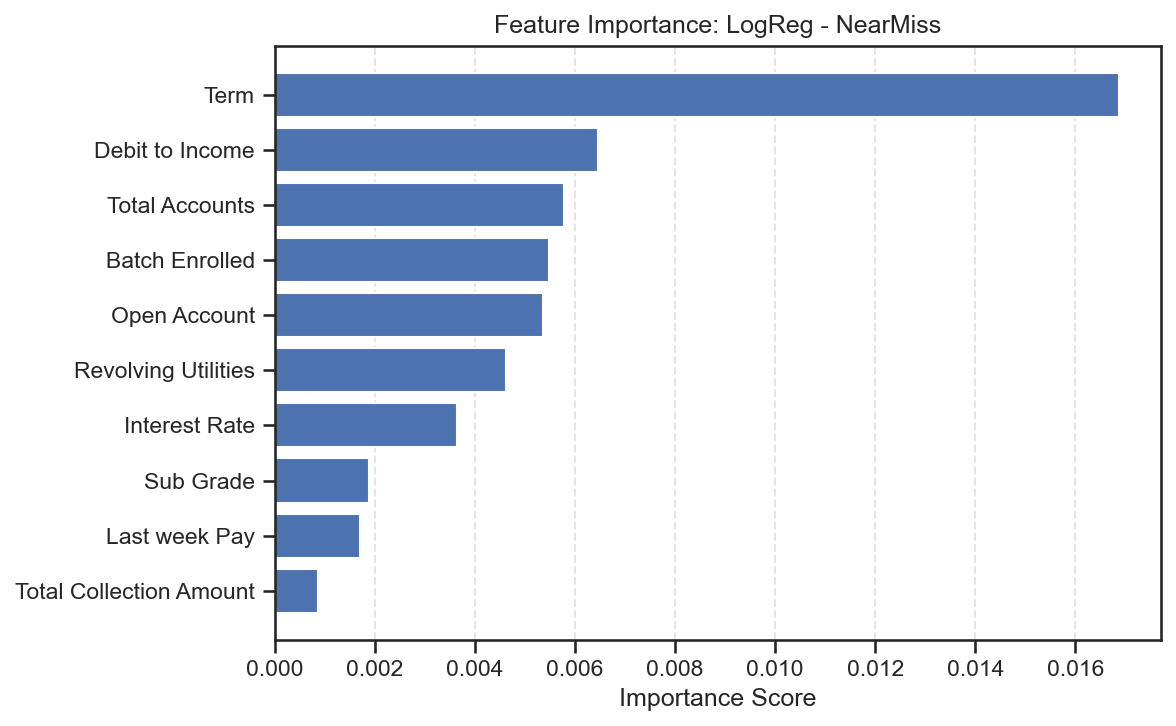

Saved: ../results


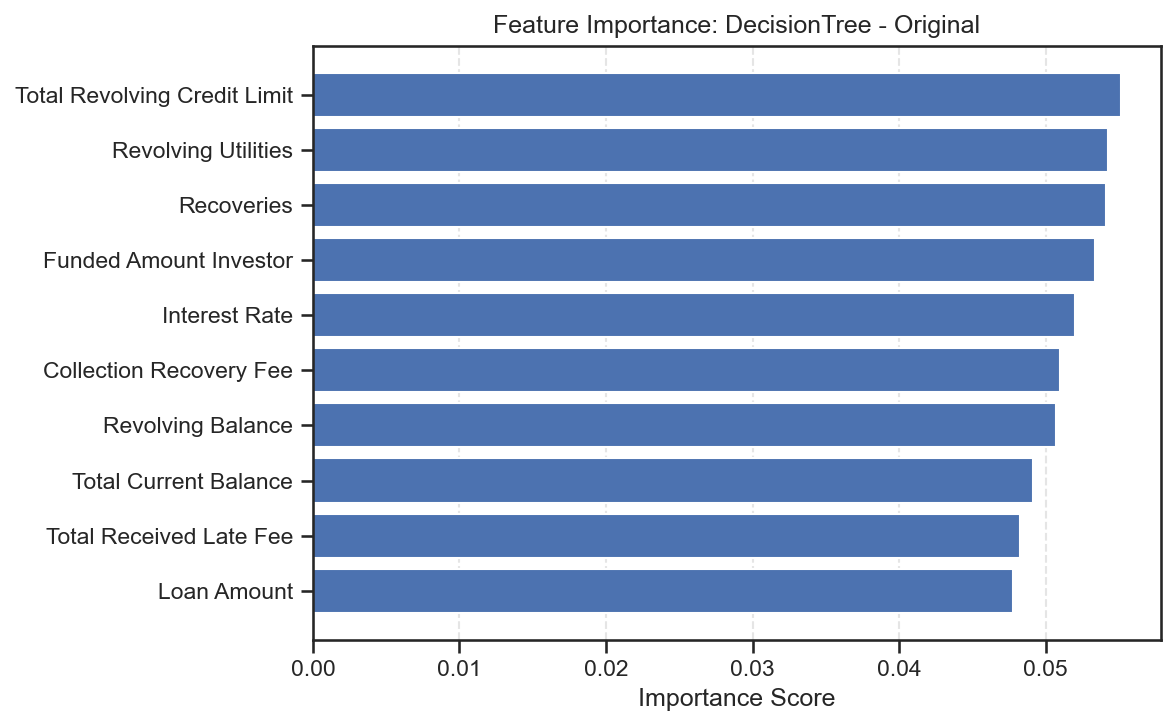

Saved: ../results


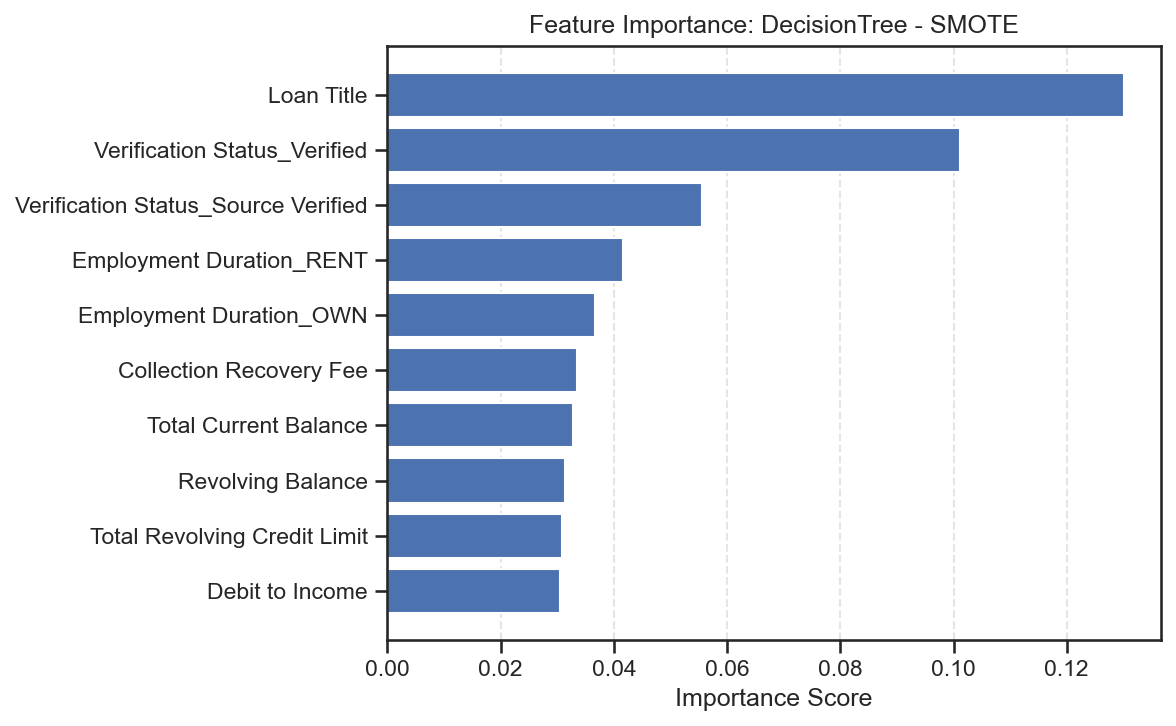

Saved: ../results


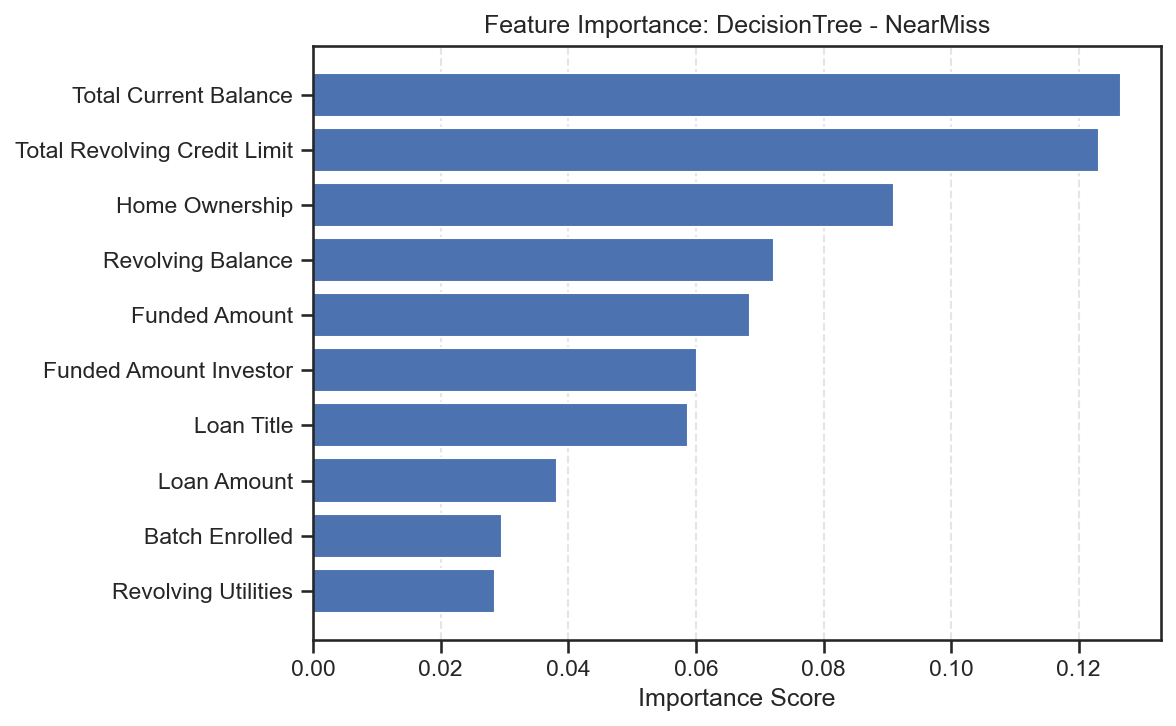

Saved: ../results


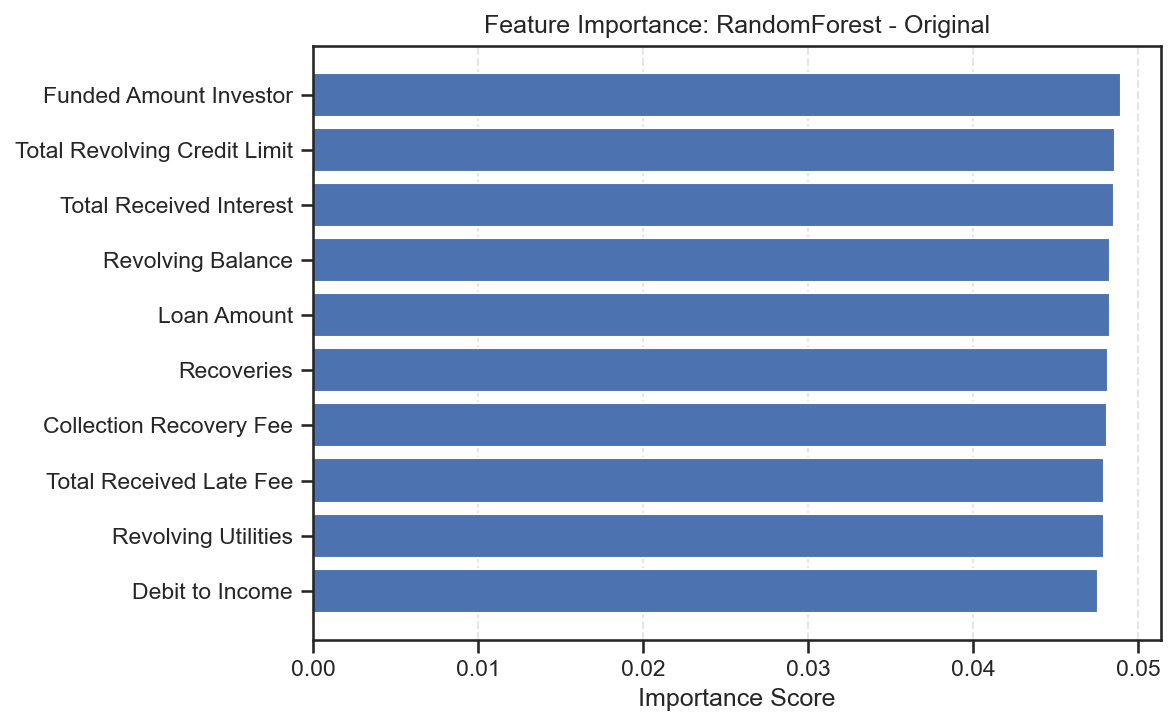

Saved: ../results


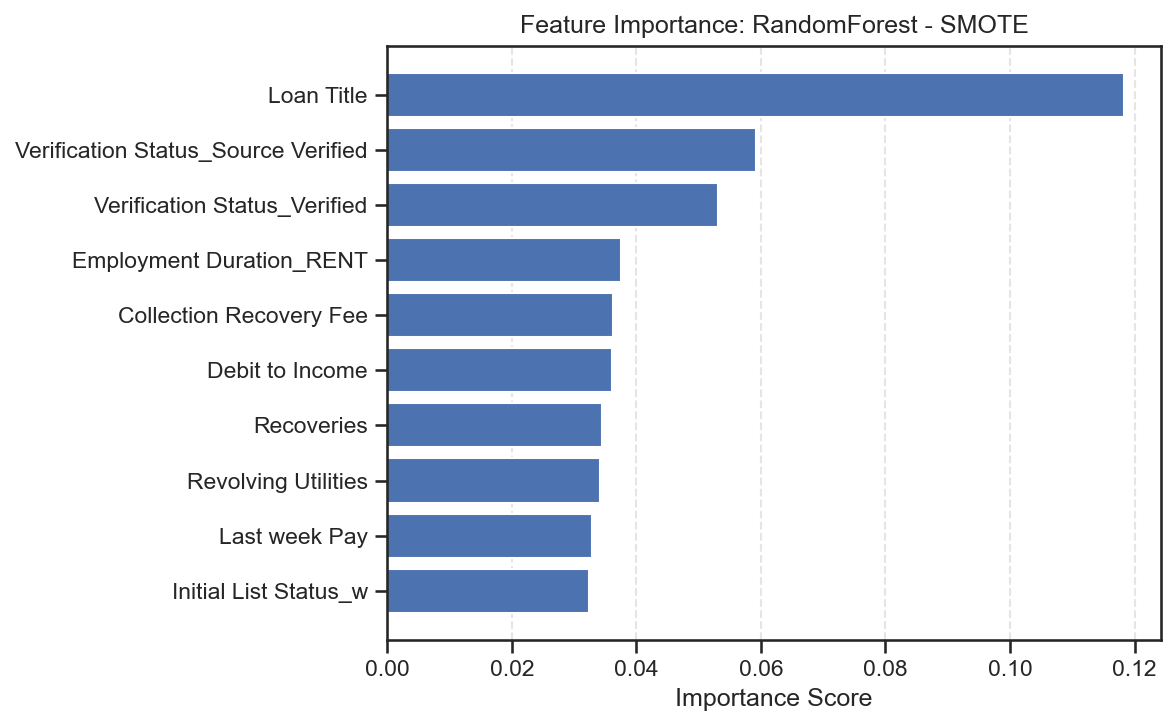

Saved: ../results


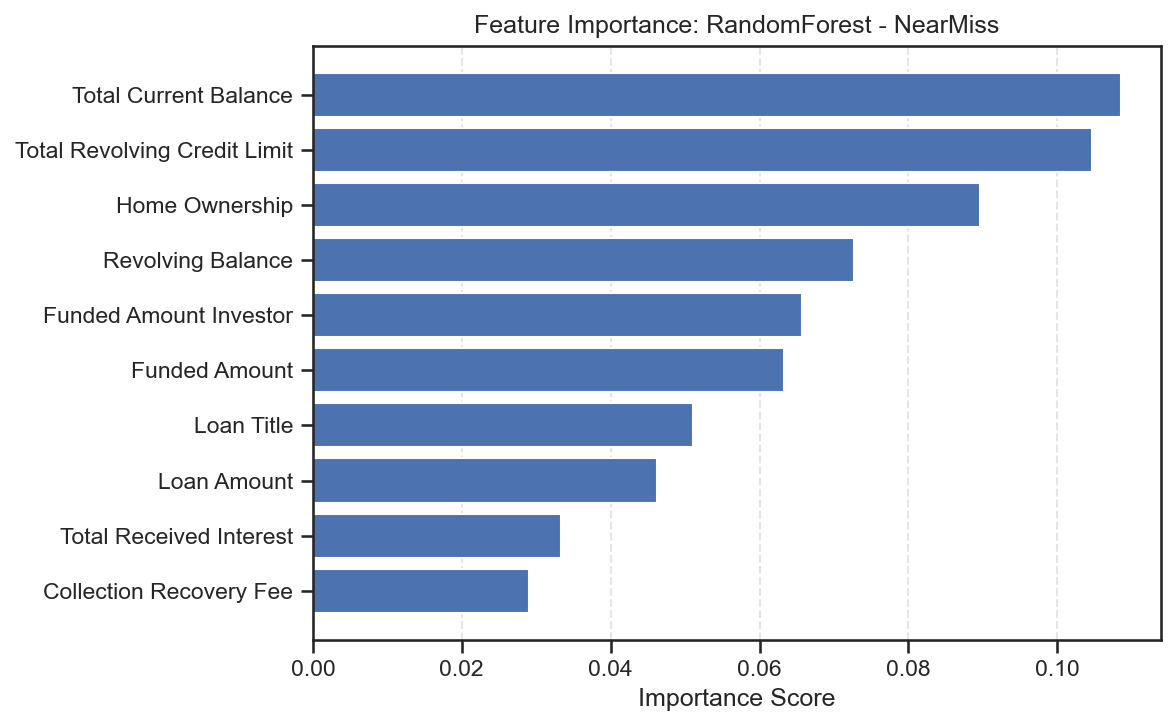

Saved: ../results


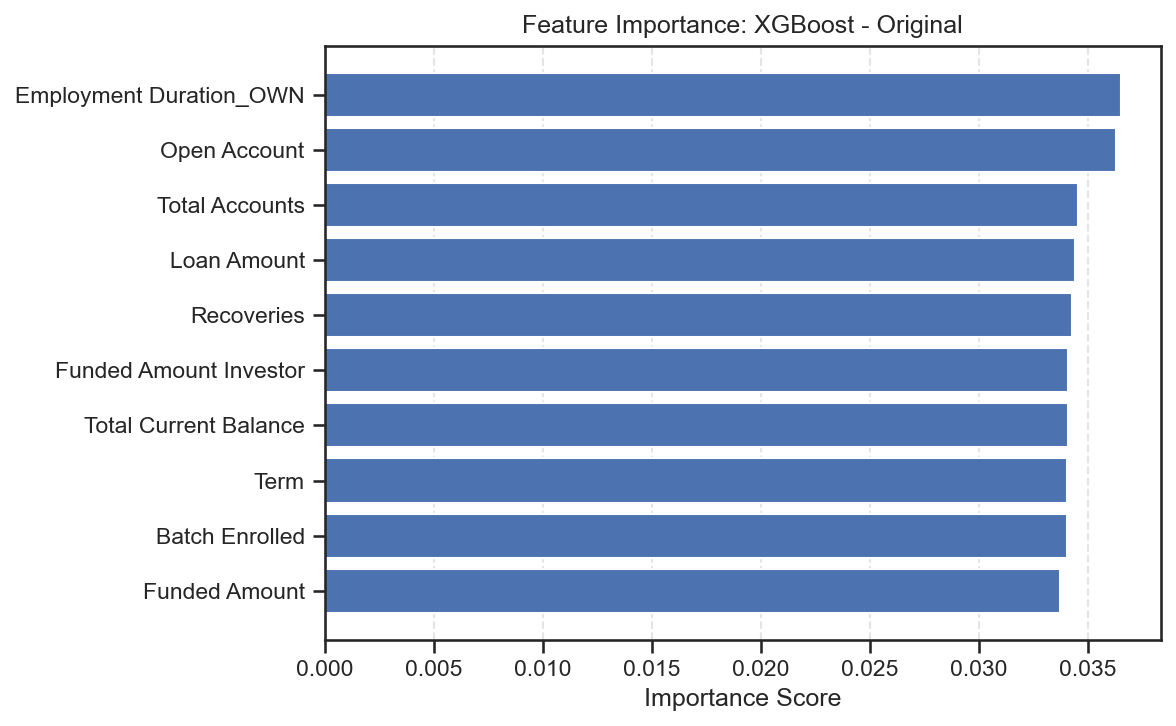

Saved: ../results


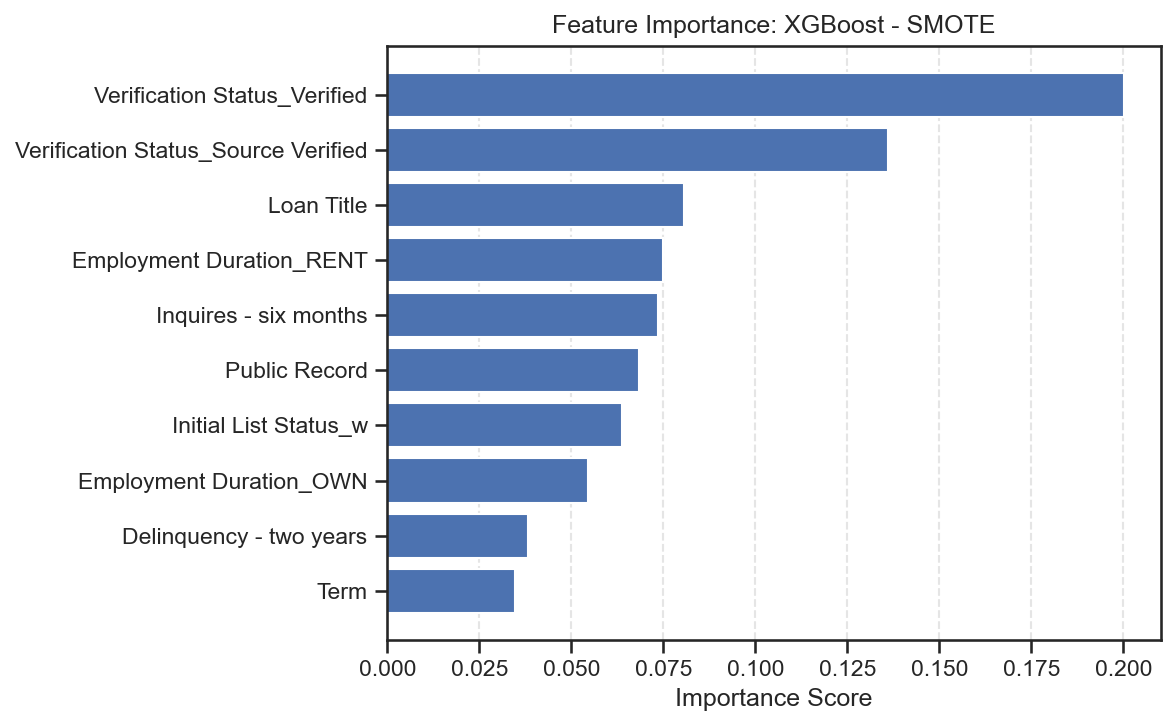

Saved: ../results


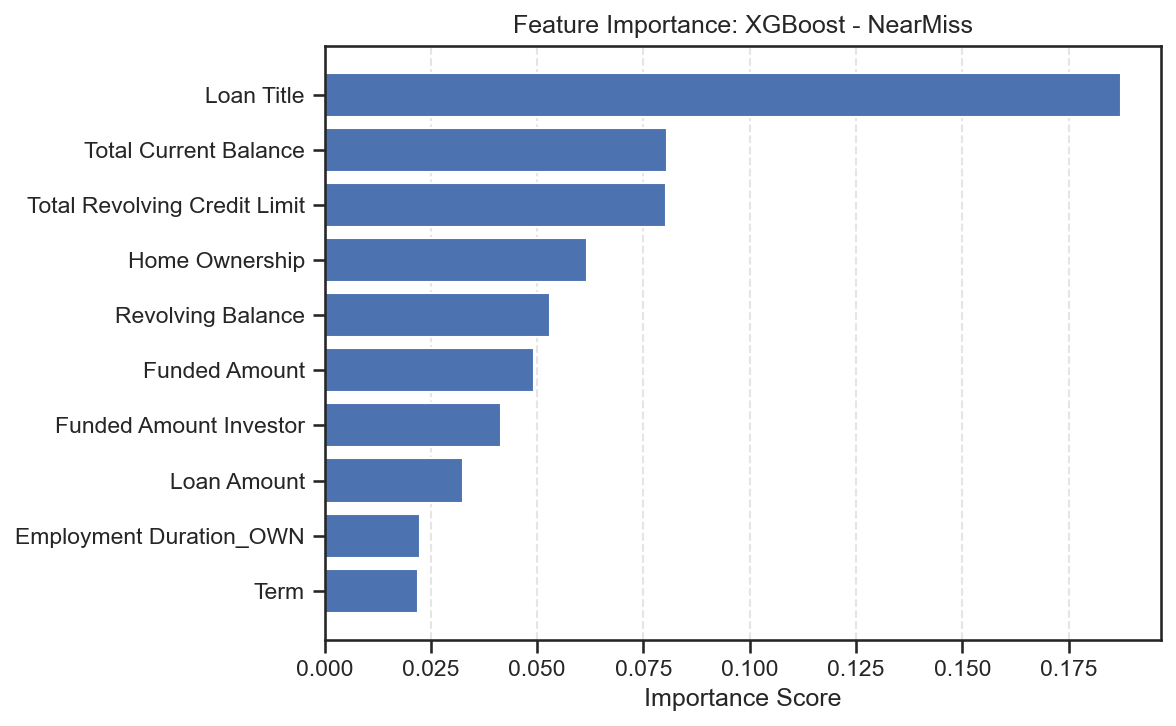

In [88]:
# Filter tree-based models with valid feature importance ===
tree_models = model_metrices[model_metrices["Feature Importance"].notnull()].copy()

# Plot each model's top N important features ===
N = 10  # Top N features to display (change if needed)
feature_names = X_train.columns  # Ensure you're using correct feature list
count = 0
for idx, row in tree_models.iterrows():
    count += 1
    importances = np.array(row["Feature Importance"])
    
    # Get indices of top N features
    top_idx = np.argsort(importances)[-N:][::-1]
    top_features = feature_names[top_idx]
    top_importances = importances[top_idx]
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(top_features[::-1], top_importances[::-1])  # Reversed for descending bars
    plt.title(f"Feature Importance: {row['Model']}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    fig = str(str(count) + "_" + str(row['Model']))
    savefig(fig, "../results")
    plt.show()

### With SMOTE

In [147]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
param_grid = {'max_depth': [3, 4, 5], 'max_features': ['int', 'sqrt', 'log2']}
modelgrid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, cv=cv, scoring='neg_log_loss')
modelgrid.fit(X_smote_train, y_smote_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.0s
[CV 2/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.0s
[CV 3/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.0s
[CV 4/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.0s
[CV 5/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.0s
[CV 1/5] END ...max_depth=3, max_features=sqrt;, score=-0.598 total time=   4.4s
[CV 2/5] END ...max_depth=3, max_features=sqrt;, score=-0.600 total time=   4.3s
[CV 3/5] END ...max_depth=3, max_features=sqrt;, score=-0.597 total time=   4.4s
[CV 4/5] END ...max_depth=3, max_features=sqrt;, score=-0.599 total time=   4.3s
[CV 5/5] END ...max_depth=3, max_features=sqrt;, score=-0.600 total time=   4.5s
[CV 1/5] END ...max_depth=3, max_features=log2;, score=-0.607 total time=   3.7s
[CV 2/5] END ...max_depth=3, max_features=log2;, 

/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_pa

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': ['int', 'sqrt', 'log2']},
             scoring='neg_log_loss', verbose=3)

In [148]:
modelgrid.best_params_

{'max_depth': 5, 'max_features': 'sqrt'}

In [149]:
model_rf_cv = RandomForestClassifier(max_depth=5, max_features='sqrt', random_state=42)

In [150]:
model_rf_cv.fit(X_smote_train, y_smote_train)

RandomForestClassifier(max_depth=5, random_state=42)

## Model Evaluation (Log loss metric)

In [151]:
# Get the predicting probablities
predict_train = model_rf_cv.predict_proba(X_smote_train)

In [153]:
predict_val = model_rf_cv.predict_proba(X_test)

In [154]:
log_loss(y_smote_train, predict_train), log_loss(y_test, predict_val)

(0.5411836994323141, 0.5742685144896418)

In [174]:
y_pred_cv_smt = model_rf_cv.predict(X_test)

In [175]:
acc = accuracy_score(y_test, y_pred_cv_smt)
prec = precision_score(y_test, y_pred_cv_smt, zero_division=0)
rec = recall_score(y_test, y_pred_cv_smt)
f1 = f1_score(y_test, y_pred_cv_smt)
roc_auc = roc_auc_score(y_test, predict_val[:, 1])
con_mat = confusion_matrix(y_test, y_pred_cv_smt)

print(f"Results:")
print("-" * 40)
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC Score : {roc_auc:.4f}" if roc_auc is not None else "ROC AUC not available")
print("\nConfusion Matrix:")
print(con_mat)
print("-" * 40)

Results:
----------------------------------------
Accuracy      : 0.7677
Precision     : 0.0903
Recall        : 0.1667
F1 Score      : 0.1172
ROC AUC Score : 0.4924

Confusion Matrix:
[[10150  2095]
 [ 1040   208]]
----------------------------------------


In [156]:
predict_test = model_rf_cv.predict_proba(test)

In [ ]:
predict_test

array([[0.61234954, 0.38765046],
       [0.53778501, 0.46221499],
       [0.63648086, 0.36351914],
       ...,
       [0.74662792, 0.25337208],
       [0.76313031, 0.23686969],
       [0.75185164, 0.24814836]])

# Genrate Submission file

In [158]:
final_result = pd.DataFrame(predict_test)
final_result.head()

0         1
0  0.612350  0.387650
1  0.537785  0.462215
2  0.636481  0.363519
3  0.493989  0.506011
4  0.464706  0.535294

In [159]:
submission = pd.DataFrame(final_result[1])
submission

1
0      0.387650
1      0.462215
2      0.363519
3      0.506011
4      0.535294
...         ...
28908  0.251031
28909  0.234524
28910  0.253372
28911  0.236870
28912  0.248148

[28913 rows x 1 columns]

In [160]:
submission.columns = ["Loan Status"]
submission["Loan Status"] = round(submission["Loan Status"], 6)
submission

Loan Status
0         0.387650
1         0.462215
2         0.363519
3         0.506011
4         0.535294
...            ...
28908     0.251031
28909     0.234524
28910     0.253372
28911     0.236870
28912     0.248148

[28913 rows x 1 columns]

In [161]:
submission.to_csv("../results/HS_Submission_SMT.csv", index=False)

### With Nearmiss

In [162]:
from imblearn.pipeline import Pipeline 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("nm", NearMiss()),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid = {
    "nm__version": [1, 2, 3],
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"],
}

gs = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(recall_score, pos_label=1),
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    return_train_score=True,
)

In [163]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('nm', NearMiss()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [300, 500, 800],
                         'nm__version': [1, 2, 3]},
             return_train_score=True,
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
             verbose=1)

In [164]:
# Get the predicting probablities
predict_train_gs = gs.predict_proba(X_train)

In [165]:
predict_val_gs = gs.predict_proba(X_test)

In [166]:
log_loss(y_train, predict_train_gs), log_loss(y_test, predict_val_gs)

(2.1006737176633496, 2.1165014914820612)

In [169]:
y_pred_gs = gs.predict(X_test)

In [171]:
y_test.shape

(13493,)

In [172]:
predict_val_gs.shape

(13493, 2)

In [173]:
acc = accuracy_score(y_test, y_pred_gs)
prec = precision_score(y_test, y_pred_gs, zero_division=0)
rec = recall_score(y_test, y_pred_gs)
f1 = f1_score(y_test, y_pred_gs)
roc_auc = roc_auc_score(y_test, predict_val_gs[:, 1])
con_mat = confusion_matrix(y_test, y_pred_gs)

print(f"Results:")
print("-" * 40)
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC Score : {roc_auc:.4f}" if roc_auc is not None else "ROC AUC not available")
print("\nConfusion Matrix:")
print(con_mat)
print("-" * 40)

Results:
----------------------------------------
Accuracy      : 0.2063
Precision     : 0.0922
Recall        : 0.8566
F1 Score      : 0.1664
ROC AUC Score : 0.4905

Confusion Matrix:
[[ 1714 10531]
 [  179  1069]]
----------------------------------------


In [176]:
predict_test_gs = gs.predict_proba(test)

In [177]:
predict_test_gs

array([[0.232277  , 0.767723  ],
       [0.04720978, 0.95279022],
       [0.20560127, 0.79439873],
       ...,
       [0.25923396, 0.74076604],
       [0.21783299, 0.78216701],
       [0.21735404, 0.78264596]])

# Genrate Submission file

In [178]:
final_result = pd.DataFrame(predict_test_gs)
final_result.head()

0         1
0  0.232277  0.767723
1  0.047210  0.952790
2  0.205601  0.794399
3  0.028958  0.971042
4  0.051041  0.948959

In [179]:
submission = pd.DataFrame(final_result[1])
submission

1
0      0.767723
1      0.952790
2      0.794399
3      0.971042
4      0.948959
...         ...
28908  0.710178
28909  0.750617
28910  0.740766
28911  0.782167
28912  0.782646

[28913 rows x 1 columns]

In [180]:
submission.columns = ["Loan Status"]
submission["Loan Status"] = round(submission["Loan Status"], 6)
submission

Loan Status
0         0.767723
1         0.952790
2         0.794399
3         0.971042
4         0.948959
...            ...
28908     0.710178
28909     0.750617
28910     0.740766
28911     0.782167
28912     0.782646

[28913 rows x 1 columns]

In [181]:
submission.to_csv("../results/HS_Submission_NM_GS.csv", index=False)

In [144]:
from scipy.stats import randint
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("nm", NearMiss()),  # sampler runs per fold; can be toggled off via grid
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist = {
    # toggle sampler + its most impactful knob
    "nm": [NearMiss(version=1), NearMiss(version=3), "passthrough"],
    # smaller, high-impact RF knobs for recall
    "clf__n_estimators": randint(120, 320),          # smaller during search; retrain bigger later
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": randint(2, 10),
    "clf__min_samples_leaf": randint(1, 6),
    "clf__max_features": ["sqrt", "log2"],           # stable choices for high-dim tabular
    "clf__class_weight": [None, "balanced"]          # compare against no-sampler path
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=48,                         # ~5–10× fewer fits than your grid
    scoring=make_scorer(recall_score, pos_label=1),
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=1,
    return_train_score=True,
)


In [146]:
rs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('nm', NearMiss()),
                                             ('clf',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=48, n_jobs=-1,
                   param_distributions={'clf__class_weight': [None, 'balanced'],
                                        'clf__max_depth': [None, 10, 20],
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf...
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x38231e650>,
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x381ffd590>,
                                        'nm': [NearMiss(), NearMiss(version=3),
                                               'passthrough']},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
                   verbose=1)

In [182]:
# Get the predicting probablities
predict_train_rs = rs.predict_proba(X_train)

In [183]:
predict_val_rs = rs.predict_proba(X_test)

In [184]:
log_loss(y_train, predict_train_rs), log_loss(y_test, predict_val_rs)

(1.173555218597324, 1.2118421903084287)

In [185]:
y_pred_rs = gs.predict(X_test)

In [186]:
acc = accuracy_score(y_test, y_pred_rs)
prec = precision_score(y_test, y_pred_rs, zero_division=0)
rec = recall_score(y_test, y_pred_rs)
f1 = f1_score(y_test, y_pred_rs)
roc_auc = roc_auc_score(y_test, predict_val_rs[:, 1])
con_mat = confusion_matrix(y_test, y_pred_rs)

print(f"Results:")
print("-" * 40)
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC Score : {roc_auc:.4f}" if roc_auc is not None else "ROC AUC not available")
print("\nConfusion Matrix:")
print(con_mat)
print("-" * 40)

Results:
----------------------------------------
Accuracy      : 0.2063
Precision     : 0.0922
Recall        : 0.8566
F1 Score      : 0.1664
ROC AUC Score : 0.5099

Confusion Matrix:
[[ 1714 10531]
 [  179  1069]]
----------------------------------------


### Feature Importance Plot for Final Random Forest Model

In [134]:
# Extract trained model from GridSearchCV
final_rf = modelgrid.best_estimator_
final_rf

RandomForestClassifier(max_depth=5, max_features=0.5)

In [135]:
# Get feature importances
importances = final_rf.feature_importances_
feature_names = X.columns  # Make sure this matches the columns used in training

In [136]:
# Create a DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

In [137]:
# Display Top 20 Features
top_n = 10
top_features = importances_df.head(top_n)

Saved: ../results


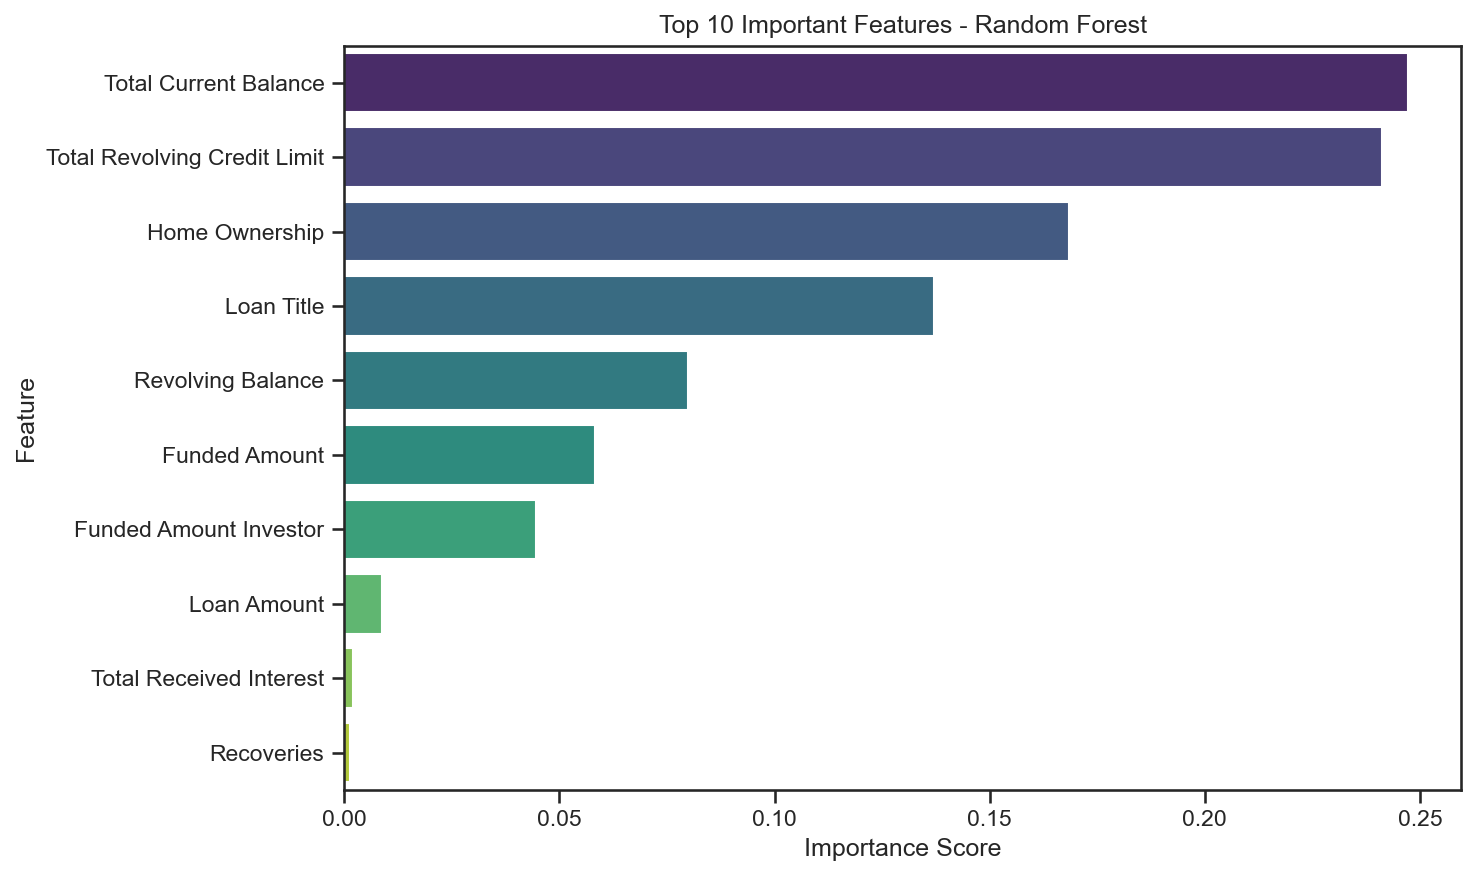

In [138]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features, palette="viridis")
plt.title(f"Top {top_n} Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
savefig("13_ImportantFeatures_RF.png", "../results")
plt.show()